# Workflow to Validate NISAR L2 Coseismic Displacement Requirement

**Original code authored by:** David Bekaert, Heresh Fattahi, Eric Fielding, and Zhang Yunjun 

Extensive modifications by Adrian Borsa and Amy Whetter 2022

Subsequent updates and reformatting by Rob Zinke, Katia Tymofyeyeva and Adrian Borsa 2025

<div class="alert alert-warning">
Step 1 of the validation workflow is executed in the **ARIA_prep** notebook. All processing steps in this notebook MUST be run sequentially, although several are optional and can be skipped.
</div>

<hr/>

<hr/>

## Table of Contents:
<a id='example_TOC'></a>

[**Environment Setup**](#setup)

[**1. Download and Prepare Interferograms**](#prep_ifg)

[**2. Generation of Time Series from Interferograms**](#gen_ts)
- [2.1. Validate/Modify Interferogram Network](#validate_network)
- [2.2. Generate Quality Control Mask](#generate_mask)
- [2.3. Reference Interferograms To Common Lat/Lon](#common_latlon)
- [2.4. Invert for SBAS Line-of-Sight Timeseries](#invert_SBAS)

[**3. Optional Corrections**](#opt_correction)
- [3.1. Solid Earth Tides Correction](#solid_earth)
- [3.2. Tropospheric Delay Correction](#tropo_corr)
- [3.3. Phase Deramping ](#phase_deramp)
- [3.4. Topographic Residual Correction ](#topo_corr) 

[**4. Decomposition of InSAR and GNSS Time Series into Basis Functions**](#decomp_ts)
- [4.1. Estimate InSAR LOS Velocities and Steps](#insar_vel)
- [4.2. Estimate InSAR Coseismic Displacement](#co_step)
- [4.3. Find Collocated GNSS Stations](#find_gps)  
- [4.4. Get GNSS Position Time Series](#gps_ts) 
- [4.5. Make GNSS LOS Velocities/Displacements](#gps_los)
- [4.6. Re-reference GNSS and InSAR LOS Coseismic Step](#reference)

[**5. NISAR Validation Approach 1: GNSS-InSAR Direct Comparison**](#validation1)
- [5.1. Make GNSS-InSAR Displacement Residuals at GNSS Station Locations](#make_resids)
- [5.2. Make Double-differenced Displacement Residuals](#make_ddiff)
- [5.3. Amplitude vs. Distance of Double-differences (not quite a structure function)](#amp_vs_dist)

[**6. NISAR Validation Approach 2: InSAR-only Structure Function**](#nisar_validation2)
- [6.1. Read Array and Mask Pixels with no Data](#array_mask)
- [6.2. Randomly Sample Pixels and Pair Them Up with Option to Remove Trend](#remove_trend)
- [6.3. Coseismic Requirement Validation: Method 2](#validation2)

[**Appendix: Supplementary Comparisons and Plots**](#appendix)
- [A.1. Compare Raw Velocities](#compare_raw)
- [A.2. Plot Velocity Residuals](#plot_residuals)
- [A.3. Plot Double-differenced Residuals](#plot_ddiff)
- [A.4. GNSS Time-series Plots](#plot_timeseries)

<hr/>

## Environment Setup<a id='#setup'></a>

### Load Python Packages<a id='#load_packages'></a>

In [1]:
import os
import json
import subprocess
import warnings
from datetime import datetime as dt, timedelta

import numpy as np
from scipy import signal
from matplotlib import pyplot as plt
import matplotlib.patches as patches

from mintpy.cli import plot_network, view
from mintpy.utils import readfile, ptime, time_func, utils as ut
from mintpy.objects import gnss, timeseries
from mintpy.smallbaselineApp import TimeSeriesAnalysis

from solid_utils.fitting import IterativeOutlierFit
from solid_utils.sampling import SiteDisplacement, load_geo, samp_pair, profile_samples, haversine_distance
from solid_utils.plotting import display_coseismic_validation, display_validation_table

### Define Calval Site and Parameters<a id='set_calval_params'></a>

In [2]:
# Specify a calval location ID from my_sites.txt
site='test' 
site = 'RidgecrestD71'

# Choose the requirement to validate, i.e., Coseismic
# Options: 'Secular' 'Coseismic' 'Transient'
requirement = 'Coseismic'

# What dataset are you processing?
#'ARIA_S1' (old directory structure for Sentinel-1 testing with aria-tools)
#'ARIA_S1_new' (new directory structure for Sentinel-1 testing with aria-tools)
dataset = 'ARIA_S1_new'
aria_gunw_version = '3_0_1'

# The date and version of this Cal/Val run
rundate = '20250210'
version = '1'

# Provide the file where you keep your customized list of sites
sites_file = '/home/jovyan/my_sites.txt'

# Enter a username for storing your outputs
if os.path.exists('/home/jovyan/me.txt'):
    with open('/home/jovyan/me.txt') as m:
        you = m.readline().strip()
else:
    you = input('Please type a username for your calval outputs:')
    with open('/home/jovyan/me.txt', 'w') as m:
        m.write(you)

# Load metadata for calval locations
with open(sites_file, 'r') as fid:
    sitedata = json.load(fid)

# Plot parameters
vmin, vmax = -500, 500  # mm
cmap = plt.get_cmap('RdBu_r')
cmap_err = plt.get_cmap('cividis')

### Set Directories and Files<a id='set_directories'></a>

In [3]:
# Directory location for Cal/Val data (do not change)
start_directory = '/scratch/nisar-st-calval-solidearth' 

# Site directory
site_dir = os.path.join(start_directory, dataset, site)

# Working directory for calval processing
work_dir = os.path.join(site_dir, requirement, you, rundate, 'v' + version)
print("  Work directory:", work_dir)

# Directory for storing GUNW interferograms
gunw_dir = os.path.join(site_dir,'products')
print("  GUNW directory:", gunw_dir) 

# Directory for storing MintPy outputs
mintpy_dir = os.path.join(work_dir,'MintPy')
print("MintPy directory:", mintpy_dir)

# Flag missing MintPy directory
if not os.path.exists(mintpy_dir):
    print()
    print('ERROR: Stop! Your MintPy processing directory does not exist for this requirement, site, version, or date of your ATBD run.')
    print('You may need to run the prep notebook first!')
    print()
else:
    os.chdir(mintpy_dir)

# Set MintPy filenames
vel_file = os.path.join(mintpy_dir, 'velocity.h5')
msk_file = os.path.join(mintpy_dir, 'maskConnComp.h5')  # maskTempCoh.h5

  Work directory: /scratch/nisar-st-calval-solidearth/ARIA_S1_new/RidgecrestD71/Coseismic/rzinke/20250210/v1
  GUNW directory: /scratch/nisar-st-calval-solidearth/ARIA_S1_new/RidgecrestD71/products
MintPy directory: /scratch/nisar-st-calval-solidearth/ARIA_S1_new/RidgecrestD71/Coseismic/rzinke/20250210/v1/MintPy


<br>
<hr>

<a id='#prep_ifg'></a>
## 1. Download and Prepare Interferograms

Executed in *ARIA_prep* notebook

<br>
<hr>

<a id='#gen_ts'></a>
## 2. Generation of Time Series from Interferograms

<a id='validate_network'></a>
### 2.1. Validate/Modify Interferogram Network

Add additional parameters to config_file in order to remove selected interferograms, change minimum coherence, etc.

MintPy version 1.6.1, date 2024-07-31
--RUN-at-2025-03-29 05:32:22.227595--
Current directory: /scratch/nisar-st-calval-solidearth/ARIA_S1_new/RidgecrestD71/Coseismic/rzinke/20250210/v1/MintPy
Run routine processing with smallbaselineApp.py on steps: ['modify_network']
Remaining steps: ['reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_ionosphere', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: RidgecrestD71
Go to work directory: /scratch/nisar-st-calval-solidearth/ARIA_S1_new/RidgecrestD71/Coseismic/rzinke/20250210/v1/MintPy
read custom template file: /scratch/nisar-st-calval-solidearth/ARIA_S1_new/RidgecrestD71/Coseismic/rzinke/20250210/v1/MintPy/RidgecrestD71.cfg
update default template based on input custom template
No new option value found, skip updating /scr

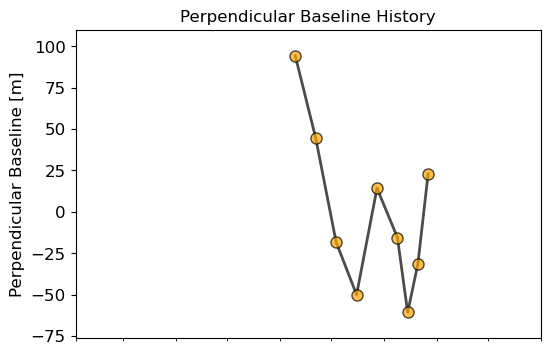

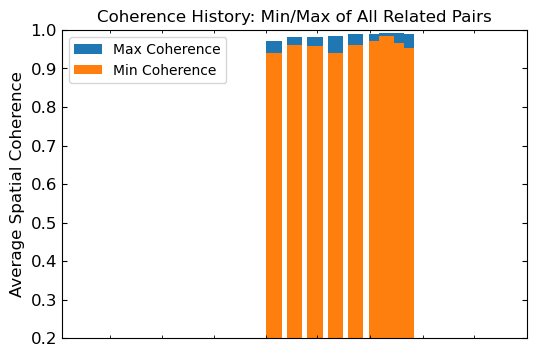

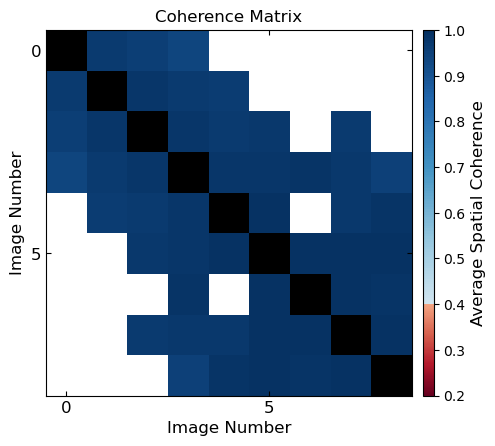

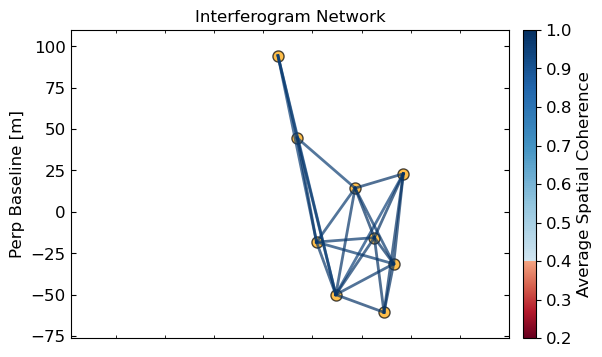

In [4]:
config_file = os.path.join(mintpy_dir,site + '.cfg')
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep modify_network'
process = subprocess.run(command, shell=True)

plot_network.main(['inputs/ifgramStack.h5'])

<a id='generate_mask'></a>
### 2.2. Generate Quality Control Mask


Mask files can be can be used to mask pixels in the time-series processing. Below we generate an initial mask file `maskConnComp.h5` based on the connected components for all the interferograms, which is a metric for unwrapping quality. After time-series analysis is complete, we will calculate a mask from the temporal coherence or variation of phase or displacement with time to make `maskTempCoh.h5`.

input ifgramStack file: inputs/ifgramStack.h5
--------------------------------------------------
update mode: ON
1) output file maskConnComp.h5 already exists.
2) output file is newer than input dataset: connectComponent.
run or skip: skip.
run view.py in MintPy version 1.6.1, date 2024-07-31
input file is mask file: /scratch/nisar-st-calval-solidearth/ARIA_S1_new/RidgecrestD71/Coseismic/rzinke/20250210/v1/MintPy/maskConnComp.h5 in bool format
file size in y/x: (3001, 3361)
input dataset: "['mask']"
num of datasets in file maskConnComp.h5: 1
datasets to exclude (0):
[]
datasets to display (1):
['mask']
data   coverage in y/x: (0, 0, 3361, 3001)
subset coverage in y/x: (0, 0, 3361, 3001)
data   coverage in lat/lon: (-118.90009512, 37.20002976, -116.099259546, 34.699194426000005)
subset coverage in lat/lon: (-118.90009512, 37.20002976, -116.099259546, 34.699194426000005)
------------------------------------------------------------------------
colormap: jet
figure title: maskConnComp
figu

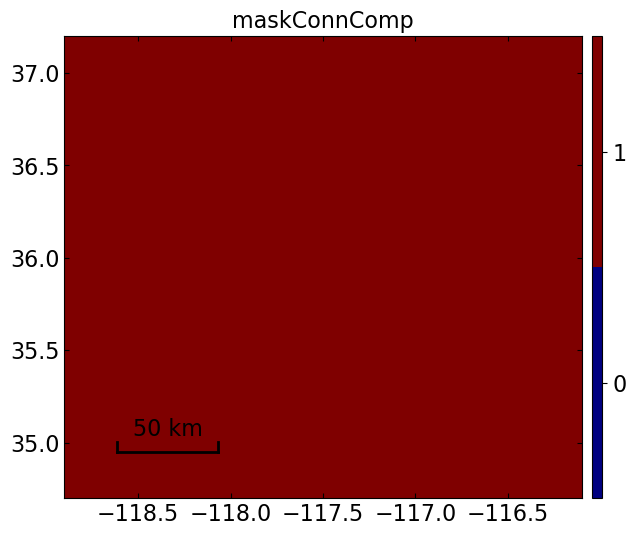

In [5]:
command='generate_mask.py inputs/ifgramStack.h5  --nonzero  -o maskConnComp.h5  --update'
process = subprocess.run(command, shell=True)
view.main(['maskConnComp.h5', 'mask'])

<a id='common_latlon'></a>
### 2.3. Reference Interferograms To Common Lat/Lon


In [6]:
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep reference_point'
process = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, shell=True)
os.system('info.py inputs/ifgramStack.h5 | egrep "REF_"');

  REF_LAT                                         36.366279093
  REF_LON                                         -116.492176527
  REF_X                                           2889
  REF_Y                                           1000


<a id='invert_SBAS'></a>
### 2.4. Invert for SBAS Line-of-Sight Timeseries


In [7]:
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep invert_network'
process = subprocess.run(command, shell=True)

MintPy version 1.6.1, date 2024-07-31
--RUN-at-2025-03-29 05:32:38.151480--
Current directory: /scratch/nisar-st-calval-solidearth/ARIA_S1_new/RidgecrestD71/Coseismic/rzinke/20250210/v1/MintPy
Run routine processing with smallbaselineApp.py on steps: ['invert_network']
Remaining steps: ['correct_LOD', 'correct_SET', 'correct_ionosphere', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: RidgecrestD71
Go to work directory: /scratch/nisar-st-calval-solidearth/ARIA_S1_new/RidgecrestD71/Coseismic/rzinke/20250210/v1/MintPy
read custom template file: /scratch/nisar-st-calval-solidearth/ARIA_S1_new/RidgecrestD71/Coseismic/rzinke/20250210/v1/MintPy/RidgecrestD71.cfg
update default template based on input custom template
No new option value found, skip updating /scratch/nisar-st-calval-solidearth/ARIA_S1_new/RidgecrestD71/Coseismic/rzinke/2025

<br>
<hr>

<a id='opt_correction'></a>
## 3. Optional Corrections

Phase distortions related to solid earth and ocean tidal effects as well as those due to temporal variations in the vertical stratification of the atmosphere can be mitigated using the approaches described below. At this point, it is expected that these corrections will not be needed to validate the mission requirements, but they may be used to produce the highest quality data products. Typically, these are applied to the estimated time series product rather than to the individual interferograms, since they are a function of the time of each radar acquisition.

<a id='solid_earth'></a>
### 3.1. Solid Earth Tides Correction

[MintPy provides functionality for this correction, but it is not part of this notebook.]

<a id='tropo_corr'></a>
### 3.2. Tropospheric Delay Correction

Optional atmospheric correction utilizes the PyAPS (Jolivet et al., 2011, Jolivet and Agram, 2012) module within GIAnT (or eventually a merged replacement for GIAnT and MintPy). PyAPS is well documented, maintained and can be freely downloaded. PyAPS is included in GIAnT distribution). PyAPS currently includes support for ECMWF’s ERA-Interim, NOAA’s NARR and NASA’s MERRA weather models. A final selection of atmospheric models to be used for operational NISAR processing will be done during Phase C.

[T]ropospheric delay maps are produced from atmospheric data provided by Global Atmospheric Models. This method aims to correct differential atmospheric delay correlated with the topography in interferometric phase measurements. Global Atmospheric Models (hereafter GAMs)... provide estimates of the air temperature, the atmospheric pressure and the humidity as a function of elevation on a coarse resolution latitude/longitude grid. In PyAPS, we use this 3D distribution of atmospheric variables to determine the atmospheric phase delay on each pixel of each interferogram.

The absolute atmospheric delay is computed at each SAR acquisition date. For a pixel a_i at an elevation z at acquisition date i, the four surrounding grid points are selected and the delays for their respective elevations are computed. The resulting delay at the pixel a_i is then the bilinear interpolation between the delays at the four grid points. Finally, we combine the absolute delay maps of the InSAR partner images to produce the differential delay maps used to correct the interferograms.

REFERENCE: [https://github.com/insarlab/pyaps#2-account-setup-for-era5]
Read Section 2 for ERA5 (link above) to create an account for the CDS website.

In [8]:
if 'do_tropo_correction' in sitedata['sites'][site].keys():
    do_tropo_correction = sitedata['sites'][site]['do_tropo_correction']
else:
    do_tropo_correction = 'False'

if do_tropo_correction == 'True':
    if not Use_Staged_Data and not os.path.exists(Path.home()/'.cdsapirc'):
        print('NEEDED to download ERA5, link: https://cds.climate.copernicus.eu/user/register')
        UID = input('Please type your CDS_UID:')
        CDS_API = input('Please type your CDS_API:')
        
        cds_tmp = '''url: https://cds.climate.copernicus.eu/api/v2
        key: {UID}:{CDS_API}'''.format(UID=UID, CDS_API=CDS_API)
        os.system('echo "{cds_tmp}" > ~/.cdsapirc; chmod 600 ~/.cdsapirc'.format(cds_tmp = str(cds_tmp)))
    
    command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep correct_troposphere'
    process = subprocess.run(command, shell=True)
    
    view.main(['inputs/ERA5.h5'])
    timeseries_filename = 'timeseries_ERA5.h5'
else:
    timeseries_filename = 'timeseries.h5'

<a id='phase_deramp'></a>
### 3.3. Phase Deramping


In [9]:
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep deramp'
process = subprocess.run(command, shell=True)

MintPy version 1.6.1, date 2024-07-31
--RUN-at-2025-03-29 05:32:42.661386--
Current directory: /scratch/nisar-st-calval-solidearth/ARIA_S1_new/RidgecrestD71/Coseismic/rzinke/20250210/v1/MintPy
Run routine processing with smallbaselineApp.py on steps: ['deramp']
Remaining steps: ['correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: RidgecrestD71
Go to work directory: /scratch/nisar-st-calval-solidearth/ARIA_S1_new/RidgecrestD71/Coseismic/rzinke/20250210/v1/MintPy
read custom template file: /scratch/nisar-st-calval-solidearth/ARIA_S1_new/RidgecrestD71/Coseismic/rzinke/20250210/v1/MintPy/RidgecrestD71.cfg
update default template based on input custom template
No new option value found, skip updating /scratch/nisar-st-calval-solidearth/ARIA_S1_new/RidgecrestD71/Coseismic/rzinke/20250210/v1/MintPy/smallbaselineApp.cfg
read default template file: /scratch/nisar-st-calval-soli

<a id='topo_corr'></a>
### 3.4. Topographic Residual Correction

In [10]:
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep correct_topography'
process = subprocess.run(command, shell=True)

MintPy version 1.6.1, date 2024-07-31
--RUN-at-2025-03-29 05:32:43.778121--
Current directory: /scratch/nisar-st-calval-solidearth/ARIA_S1_new/RidgecrestD71/Coseismic/rzinke/20250210/v1/MintPy
Run routine processing with smallbaselineApp.py on steps: ['correct_topography']
Remaining steps: ['residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: RidgecrestD71
Go to work directory: /scratch/nisar-st-calval-solidearth/ARIA_S1_new/RidgecrestD71/Coseismic/rzinke/20250210/v1/MintPy
read custom template file: /scratch/nisar-st-calval-solidearth/ARIA_S1_new/RidgecrestD71/Coseismic/rzinke/20250210/v1/MintPy/RidgecrestD71.cfg
update default template based on input custom template
No new option value found, skip updating /scratch/nisar-st-calval-solidearth/ARIA_S1_new/RidgecrestD71/Coseismic/rzinke/20250210/v1/MintPy/smallbaselineApp.cfg
read default template file: /scratch/nisar-st-calval-solidearth/ARI

<br>
<hr>

<a id='decomp_ts'></a>
## 4. Decomposition of InSAR and GNSS Time Series into Basis Functions

<a id='insar_vel'></a>
### 4.1. Estimate InSAR LOS Velocities and Steps

Given a time series of InSAR LOS displacements, the observations for a given pixel, $U(t)$, can be parameterized as:

$$ U(t) = a \;+\; vt \;+\; c_1 cos (\omega_1t - \phi_{1,}) \;+\; c_2 cos (\omega_2t - \phi_2) \;+\; \sum_{j=1}^{N_{eq}} \left( h_j+f_j F_j (t-t_j) \right)H(t - t_j) \;+\; \frac{B_\perp (t)}{R sin \theta}\delta z \;+\; residual$$ 

which includes a constant offset $(a)$, velocity $(v)$, and amplitudes $(c_j)$ and phases $(\phi_j)$ of annual $(\omega_1)$ and semiannual $(\omega_2)$ sinusoidal terms.  Where needed we can include additional complexity, such as coseismic and postseismic processes parameterized by Heaviside (step) functions $H$ and postseismic functions $F$ (the latter typically exponential and/or logarithmic).   $B_\perp(t)$, $R$, $\theta$, and $\delta z$ are, respectively, the perpendicular component of the interferometric baseline relative to the first date, slant range distance, incidence angle and topography error correction for the given pixel. 

Thus, given either an ensemble of interferograms or the output of SBAS (displacement vs. time), we can write the LSQ problem as 

$$ \textbf{G}\textbf{m} = \textbf{d}$$

where $\textbf{G}$ is the design matrix (constructed out of the different functional terms in Equation 2 evaluated either at the SAR image dates for SBAS output, or between the dates spanned by each pair for interferograms), $\textbf{m}$ is the vector of model parameters (the coefficients in Equation 2) and $\textbf{d}$ is the vector of observations.  For GPS time series, $\textbf{G}, \textbf{d}, \textbf{m}$ are constructed using values evaluated at single epochs corresponding to the GPS solution times, as for SBAS InSAR input. 

With this formulation, we can obtain InSAR velocity estimates and their formal uncertainties (including in areas where the expected answer is zero). 

The default InSAR velocity fit in MintPy is to estimate a mean linear velocity $(v)$ in in the equation, which we do below. This is the same linear velocity used in the Secular notebook.

<div class="alert alert-warning">
If the time-series span less than one year, then annual and semi-annual fuctions might not be reliably fit for noisy data. In that case, the periodic functions will not be included in these analyses.

Note that this workflow **requires** an earthquake date to be specified.
</div>

In [11]:
# Check that an earthquake date is specified and retrieve that date
if 'earthquakeDate' in sitedata['sites'][site].keys():
    EQdate = [sitedata['sites'][site]['earthquakeDate']]
    print('Earthquake date: {:s}'.format(sitedata['sites'][site]['earthquakeDate']))
else:
    EQdate = []
    warnings.warn('No earthquake date specified. This data set might not be suitable for the coseismic workflow.')

# Specify basis functions
# Changing these might change the meaning of this exercise! Use caution if altering.
ts_functions = {
                'polynomial': 1,
                'periodic': [],  # Periodic terms are in units of years
                'stepDate': EQdate,
                'polyline': [],
                'exp': {},
                'log': {}
}

# Check that polynomial and step date are specified
if (ts_functions['polynomial'] != 1) \
    or (not ts_functions['stepDate']):
    raise Exception('A degree-1 polynomial and earthquake date must be specified')

# Determine time span to check whether fitting of periodic functions is appropriate
ts_metadata = readfile.read_attribute(timeseries_filename)
start_date = dt.strptime(sitedata['sites'][site]['download_start_date'], '%Y%m%d')
end_date = dt.strptime(sitedata['sites'][site]['download_end_date'], '%Y%m%d')
ts_timespan = (end_date - start_date).days

if (ts_timespan < 365*2) and len(ts_functions['periodic']) > 0:
    print('Time span is {:d} days'.format(ts_timespan))
    if ts_timespan < 365:
        ts_functions['periodic'] = []
        print('No periodic functions will be fit')
    else:
        warnings.warn('Warning: Periodic fits might be unreliable for series less than 2 years')

Earthquake date: 20190705


In [16]:
# Parse the TS model into argument string for command line execution
function_str = ''

# Loop through basis functions
for fcn in ts_functions.keys():
    arg = ts_functions[fcn]
    
    if fcn == 'polynomial':
        function_str += f' --polynomial {arg:d}'
    
    else:
        # Check whether values are passed
        if len(arg) > 0:
            fcn = 'step' if fcn == 'stepDate' else fcn
            # Append basis function name
            function_str += f' --{fcn:s}'

            # Append function arguments (e.g, period, decay, etc.)
            if type(arg) == list:
                function_str += ' {:s}'.format(' '.join([str(a) for a in arg]))
            elif type(arg) == dict:
                for event_date in arg.keys():
                    function_str += f' {event_date:s}'
                    for val in arg[event_date]:
                        function_str += f' {val:f}'

# Run command
command = f"timeseries2velocity.py {timeseries_filename} --poly 1"
process = subprocess.run(command, shell=True)

# Load velocity file
mean_velocities,_ = readfile.read(vel_file, datasetName = 'velocity')  # read velocity file
mean_velocities *= 1000.  # convert InSAR velocities from m/yr to mm/yr

# Load velocity err file
mean_vel_errs, _ = readfile.read(vel_file, datasetName = 'velocityStd')
mean_vel_errs *= 1000.  # m/yr to mm/yr

# Set masked pixels to NaN
msk, _ = readfile.read(msk_file)
mean_velocities[(mean_velocities == 0) | (msk == 0)] = np.nan
mean_vel_errs[np.isnan(mean_velocities)] = np.nan

open timeseries file: timeseries.h5
--------------------------------------------------
dates from input file: 9
['20190610', '20190622', '20190704', '20190716', '20190728', '20190809', '20190815', '20190821', '20190827']
--------------------------------------------------
using all dates to calculate the time function
--------------------------------------------------
estimate deformation model with the following assumed time functions:
    polynomial : 1
    periodic   : []
    stepDate   : []
    polyline   : []
    exp        : {}
    log        : {}
add/update the following configuration metadata:
['startDate', 'endDate', 'excludeDate', 'polynomial', 'periodic', 'stepDate', 'exp', 'log', 'uncertaintyQuantification', 'timeSeriesCovFile', 'bootstrapCount']
--------------------------------------------------
create HDF5 file: velocity.h5 with w mode
create dataset  : intercept    of <class 'numpy.float32'>   in size of (3001, 3361)         with compression = None
create dataset  : inter

Now we plot the mean linear velocity fit. The MintPy `view` module automatically reads the temporal coherence mask `maskTempCoh.h5` and applies that to mask out pixels with unreliable velocities (white). Because there is a large coseismic displacement at the time of the earthquake but we are only estimating a single linear velocity, it absorbs the coseismic signal in this plot.

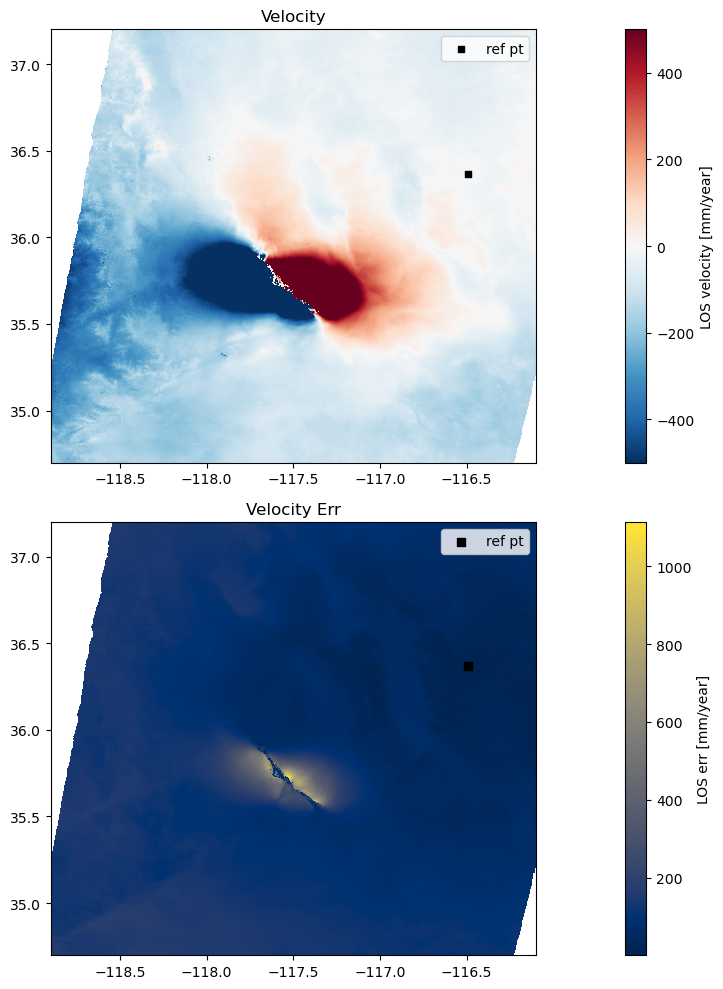

In [18]:
# Get analysis metadata from InSAR velocity file
insar_metadata = readfile.read_attribute(vel_file)
(S,N,W,E) = ut.four_corners(insar_metadata)
ref_lon = float(insar_metadata['REF_LON'])
ref_lat = float(insar_metadata['REF_LAT'])

# Plot stations in map view
fig, axes = plt.subplots(figsize=(18, 10), nrows=2)
cbar_orient = 'vertical'

# Plot velocity
cax = axes[0].imshow(mean_velocities, cmap=cmap, vmin=vmin, vmax=vmax,
                     interpolation='nearest', extent=(W, E, S, N))
cbar = fig.colorbar(cax, ax=axes[0], orientation=cbar_orient)
cbar.set_label('LOS velocity [mm/year]')

axes[0].scatter(ref_lon, ref_lat, s=4**2, c='k', marker='s',
               label='ref pt')

axes[0].legend()
axes[0].set_title('Velocity')

# Plot velocity error
cax = axes[1].imshow(mean_vel_errs, cmap=cmap_err,
                     interpolation='nearest', extent=(W, E, S, N))
cbar = fig.colorbar(cax, ax=axes[1], orientation=cbar_orient)
cbar.set_label('LOS err [mm/year]')

axes[1].scatter(ref_lon, ref_lat, s=6**2, c='k', marker='s',
               label='ref pt')

axes[1].legend()
axes[1].set_title('Velocity Err')

fig.tight_layout()

<div class="alert alert-info">
<b>Note :</b> 
Negative values indicates that target is moving away from the radar (i.e., Subsidence in case of vertical deformation).
Positive values indicates that target is moving towards the radar (i.e., uplift in case of vertical deformation). 
</div>

<a id='co_step'></a>
### 4.2. Estimate InSAR Coseismic Displacement

We can use the same time series to estimate the coseismic displacement as a Heaviside $H$ or step function at the time of an earthquake or a number $N_{eq}$ of earthquakes. In the above equation this is the $$\sum_{j=1}^{N_{eq}} \left( h_j+f_j F_j (t-t_j) \right)H(t - t_j) \;$$ set of terms. For simplicity, we consider only one earthquake and we assume the postseismic displacement functions $F$ are small compared to the coseismic displacements, so we only need to solve for the coefficient $h$ of each interferogram pixel.

We call the MintPy `timeseries2velocity.py` program again and specify the time of the earthquake $t_j$. The fit will also include the linear velocity rate separated from the step function amplitude. Both estimated coefficients have their associated uncertainties.

In [25]:
# Run command to compute velocity and step
command = f"timeseries2velocity.py {timeseries_filename} {function_str}"
process = subprocess.run(command, shell=True)

# Load velocity file
insar_velocities, _ = readfile.read(vel_file, datasetName = 'velocity')
insar_velocities *= 1000.  # m to mm

# Load displacement file
EQdataset = f"step{sitedata['sites'][site]['earthquakeDate']}"
EQstep, _ = readfile.read(vel_file, datasetName = EQdataset)
EQstep *= 1000.  # m to mm

# Load displacement err file
EQdataset_err = f"{EQdataset}Std"
EQstep_err, _ = readfile.read(vel_file, datasetName = EQdataset_err)
EQstep_err *= 1000.  # m to mm

# Set masked pixels to NaN
msk, _ = readfile.read(msk_file)
insar_velocities[(insar_velocities == 0) | (msk == 0)] = np.nan
EQstep[np.isnan(insar_velocities)] = np.nan
EQstep_err[np.isnan(insar_velocities)] = np.nan

open timeseries file: timeseries.h5
--------------------------------------------------
dates from input file: 9
['20190610', '20190622', '20190704', '20190716', '20190728', '20190809', '20190815', '20190821', '20190827']
--------------------------------------------------
using all dates to calculate the time function
--------------------------------------------------
estimate deformation model with the following assumed time functions:
    polynomial : 1
    periodic   : []
    stepDate   : ['20190705']
    polyline   : []
    exp        : {}
    log        : {}
add/update the following configuration metadata:
['startDate', 'endDate', 'excludeDate', 'polynomial', 'periodic', 'stepDate', 'exp', 'log', 'uncertaintyQuantification', 'timeSeriesCovFile', 'bootstrapCount']
--------------------------------------------------
create HDF5 file: velocity.h5 with w mode
create dataset  : intercept       of <class 'numpy.float32'>   in size of (3001, 3361)         with compression = None
create dat

Now we can view the step function amplitude and the new linear velocity estimate.

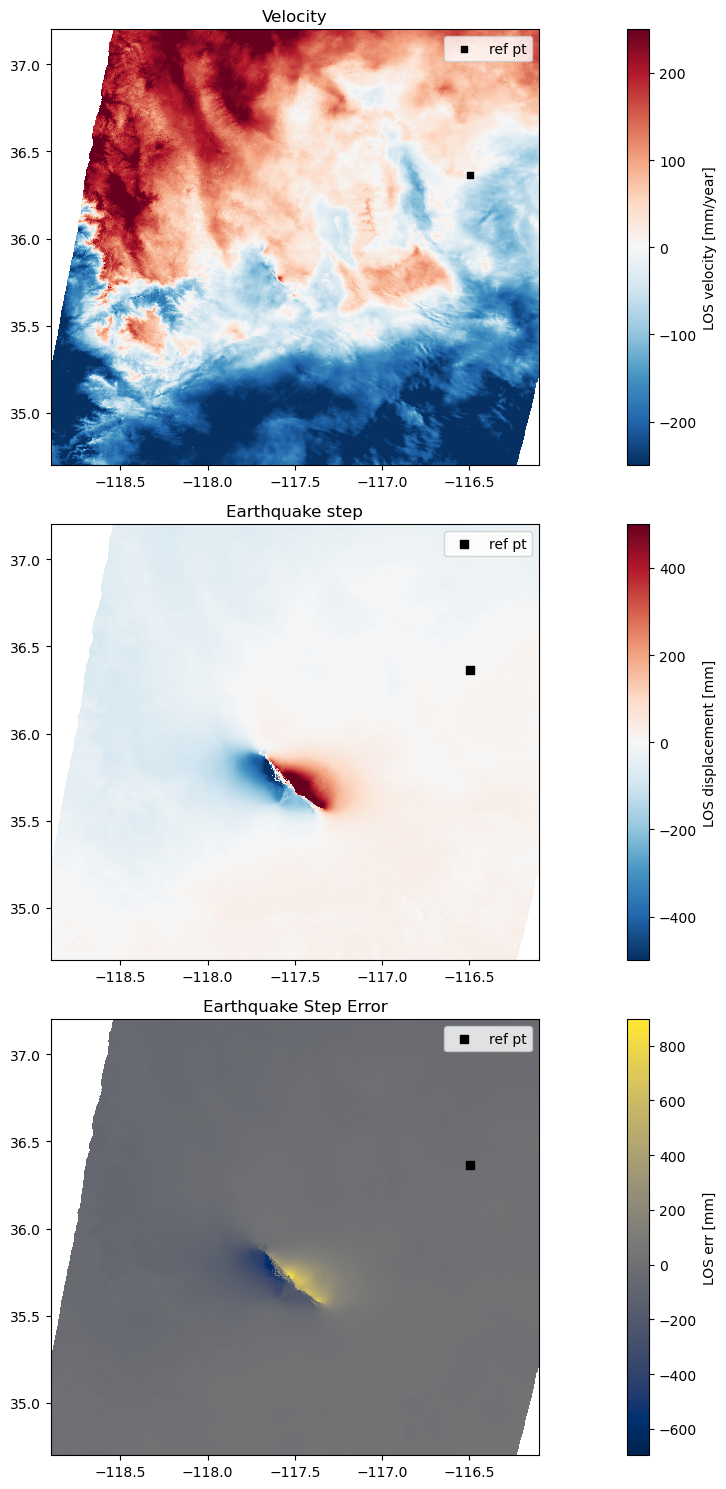

In [26]:
# Get analysis metadata from InSAR velocity file
insar_metadata = readfile.read_attribute(vel_file)
(S,N,W,E) = ut.four_corners(insar_metadata)
ref_lon = float(insar_metadata['REF_LON'])
ref_lat = float(insar_metadata['REF_LAT'])

# Plot solutions in map view
fig, axes = plt.subplots(figsize=(18, 15), nrows=3)
cbar_orient = 'vertical'

# Plot velocity
cax = axes[0].imshow(insar_velocities, cmap=cmap,
                     vmin=vmin/2, vmax=vmax/2,
                     interpolation='nearest', extent=(W, E, S, N))
cbar = fig.colorbar(cax, ax=axes[0], orientation=cbar_orient)
cbar.set_label('LOS velocity [mm/year]')
axes[0].scatter(ref_lon, ref_lat, s=4**2, c='k', marker='s',
               label='ref pt')
axes[0].legend()
axes[0].set_title('Velocity')

# Plot earthquake step solution
cax = axes[1].imshow(EQstep, cmap=cmap,
                     vmin=vmin, vmax=vmax,
                     interpolation='nearest', extent=(W, E, S, N))
cbar = fig.colorbar(cax, ax=axes[1], orientation=cbar_orient)
cbar.set_label('LOS displacement [mm]')
axes[1].scatter(ref_lon, ref_lat, s=6**2, c='k', marker='s',
               label='ref pt')
axes[1].legend()
axes[1].set_title('Earthquake step')

# Plot EQ step error
cax = axes[2].imshow(EQstep, cmap=cmap_err,
                     interpolation='nearest', extent=(W, E, S, N))
cbar = fig.colorbar(cax, ax=axes[2], orientation=cbar_orient)
cbar.set_label('LOS err [mm]')
axes[2].scatter(ref_lon, ref_lat, s=6**2, c='k', marker='s',
               label='ref pt')
axes[2].legend()
axes[2].set_title('Earthquake Step Error')

fig.tight_layout()

<a id='find_gps'></a>
### 4.3. Find Collocated GNSS Stations

The project will have access to L2 position data for continuous GNSS stations in third-party networks such NSF’s Plate Boundary Observatory, the HVO network for Hawaii, GEONET-Japan, and GEONET-New Zealand, located in target regions for NISAR solid earth calval. Station data will be post-processed by one or more analysis centers, will be freely available, and will have latencies of several days to weeks, as is the case with positions currently produced by the NSF’s GAGE Facility and separately by the University of Nevada Reno. Networks will contain one or more areas of high-density station coverage (2~20 km nominal station spacing over 100 x 100 km or more) to support validation of L2 NISAR requirements at a wide range of length scales.

MintPy supports several options for downloading and handling GNSS data. Currently supported data sets are:
* UNR National Geodetic Laboratory
* SIO/JPL MEaSUREs ESESES
* JPL SIDESHOW

In [27]:
# GNSS processing source
if 'gnss_source' in sitedata['sites'][site]:
    gnss_source = sitedata['sites'][site]['gnss_source']
else:
    gnss_source = 'UNR'
print(f"GNSS processing source: {gnss_source:s}")

# Get analysis metadata from InSAR velocity file
insar_metadata = readfile.read_attribute(vel_file)
lat_step = float(insar_metadata['Y_STEP'])
lon_step = float(insar_metadata['X_STEP'])
(S,N,W,E) = ut.four_corners(insar_metadata)
start_date = insar_metadata.get('START_DATE', None).split('T')[0]
end_date = insar_metadata.get('END_DATE', None).split('T')[0]
start_date_gnss = dt.strptime(start_date, "%Y%m%d")
end_date_gnss = dt.strptime(end_date, "%Y%m%d")

# Get center lat/lon of analysis region
bbox = sitedata['sites'][site]['analysis_region'].replace("'","").split()
lat0 = (float(bbox[0]) + float(bbox[1]))/2
lon0 = (float(bbox[2]) + float(bbox[3]))/2

# Identify geometry file x/y location associated with center lat/lon
geom_obj = mintpy_dir + '/inputs/geometryGeo.h5'
atr = readfile.read_attribute(geom_obj)
coord = ut.coordinate(atr, lookup_file=geom_obj)
y, x = coord.geo2radar(lat0, lon0)[0:2]
y = max(0, y);  y = min(int(atr['LENGTH'])-1, y)
x = max(0, x);  x = min(int(atr['WIDTH'])-1, x)

# Write out inclination/azimuth at specified x/y location
kwargs = dict(box=(x,y,x+1,y+1))
inc_angle = readfile.read(geom_obj, datasetName='incidenceAngle', **kwargs)[0][0,0]
az_angle  = readfile.read(geom_obj, datasetName='azimuthAngle',   **kwargs)[0][0,0]

# Set GNSS Parameters
gnss_completeness_threshold = 0.9    #0.9  #percent of data timespan with valid GNSS epochs
gnss_residual_stdev_threshold = 0.03  #0.03   #max threshold standard deviation of residuals to linear GNSS fit (meters)

# Search for collocated GNSS stations
site_names, _, _ = gnss.search_gnss(SNWE=(S,N,W,E),
                                    start_date=start_date,
                                    end_date=end_date,
                                    source=gnss_source)
site_names = [str(stn) for stn in site_names]

GNSS processing source: UNR
load 22294 GNSS sites with fields: site lat lon start_date end_date num_solution
keep sites within SNWE of (34.699194426, 37.20002976, -118.90009512, -116.099259546): [148]
keep sites with end_date >= 20190610: [121]
keep sites with start_date <= 20190827: [114]
keep sites with # of solutions >= 50: [114]
['ALPP' 'ASHM' 'BEAT' 'BEER' 'BEPK' 'BFSH' 'BSRY' 'CABS' 'CAC2' 'CAIS'
 'CAL8' 'CCCC' 'CDMT' 'CERR' 'COSJ' 'COSO' 'CPBN' 'CRAM' 'DEVL' 'DS13'
 'DTPG' 'EAGL' 'EDPP' 'ELTN' 'FOXG' 'FZHS' 'GOL2' 'GOLD' 'HAR7' 'HCMN'
 'HIGH' 'HIVI' 'HW95' 'INDE' 'ISLK' 'KENN' 'LAVA' 'LDSW' 'LITT' 'LJRN'
 'LNMT' 'LONP' 'NEVA' 'NVAG' 'OASI' 'OLNC' 'OWEN' 'P091' 'P092' 'P093'
 'P311' 'P462' 'P463' 'P464' 'P465' 'P466' 'P467' 'P468' 'P553' 'P554'
 'P556' 'P557' 'P558' 'P560' 'P567' 'P568' 'P569' 'P570' 'P571' 'P573'
 'P579' 'P580' 'P583' 'P588' 'P590' 'P591' 'P592' 'P593' 'P594' 'P595'
 'P596' 'P597' 'P604' 'P615' 'P616' 'P617' 'P618' 'P619' 'P620' 'P808'
 'P811' 'P812' 'PANA' 'PEA

<a id='gps_ts'></a>
### 4.4. Get GNSS Position Time Series

We download the GNSS station data, and evaluate the station data quality based on data completeness and scatter of residuals.

In [28]:
# Empty dicts and lists to store GNSS data
gnss_stns = {}
bad_stns = {}

print(f"GNSS completion threshold: {gnss_completeness_threshold}")
print(f"Residual stdev threshold: {gnss_residual_stdev_threshold}")

for site_name in site_names:
    gnss_stn = gnss.get_gnss_class(gnss_source)(site = site_name)
    gnss_stn.open(print_msg=False)

    # check if station is in masked out area
    site_lat, site_lon = gnss_stn.get_site_lat_lon()
    site_y, site_x = ut.coordinate(insar_metadata).geo2radar(site_lat, site_lon)[:2]
    masked_loc = np.isnan(insar_velocities[site_y, site_x])

    # count number of dates in time range
    dates = gnss_stn.dates
    range_days = (end_date_gnss - start_date_gnss).days
    gnss_count = np.histogram(dates, bins=[start_date_gnss, end_date_gnss])
    gnss_count = int(gnss_count[0][0])

    # get standard deviation of residuals to linear fit
    G = time_func.get_design_matrix4time_func(gnss_stn.date_list, ts_functions)
    disp_los = ut.enu2los(gnss_stn.dis_e, gnss_stn.dis_n, gnss_stn.dis_u, inc_angle, az_angle)
    m_hat = np.linalg.pinv(G).dot(disp_los)
    dis_hat = np.dot(G, m_hat)
    stn_stdv = np.std(disp_los - dis_hat)
    
    # select GNSS stations based on data completeness, scatter of residuals
    # and whether they are in masked areas
    if (range_days*gnss_completeness_threshold <= gnss_count) \
        and (stn_stdv <= gnss_residual_stdev_threshold) \
        and (masked_loc == False):
        gnss_stns[site_name] = gnss_stn
    else:
        bad_stns[site_name] = gnss_stn

# [optional] manually remove additional stations
gnss_to_remove=[]

for site_name in gnss_to_remove:
    bad_stns[site_name] = gnss_stns[site_name]
    del gnss_stns[site_name]

# Final list of site names
site_names = [*gnss_stns]
bad_site_names = [*bad_stns]

print("\nFinal list of {} stations used in analysis:".format(len(site_names)))
print(site_names)
print("List of {} stations removed from analysis".format(len(bad_site_names)))
print(bad_site_names)

GNSS completion threshold: 0.9
Residual stdev threshold: 0.03

Final list of 80 stations used in analysis:
['ASHM', 'BEAT', 'BEPK', 'BFSH', 'BSRY', 'CABS', 'CAC2', 'CAIS', 'CAL8', 'CCCC', 'CDMT', 'CPBN', 'DS13', 'DTPG', 'EDPP', 'ELTN', 'FZHS', 'GOL2', 'GOLD', 'HAR7', 'HCMN', 'HIVI', 'ISLK', 'LJRN', 'LNMT', 'NEVA', 'NVAG', 'P091', 'P092', 'P093', 'P311', 'P462', 'P463', 'P464', 'P465', 'P466', 'P467', 'P468', 'P554', 'P556', 'P557', 'P558', 'P560', 'P567', 'P568', 'P569', 'P570', 'P573', 'P579', 'P580', 'P583', 'P588', 'P590', 'P591', 'P592', 'P593', 'P594', 'P595', 'P596', 'P597', 'P604', 'P615', 'P616', 'P617', 'P619', 'P620', 'P808', 'P811', 'P812', 'RAMT', 'REPO', 'RSTP', 'RYAN', 'TEHA', 'THCP', 'TOWG', 'TPOG', 'WASG', 'WHFG', 'WORG']
List of 34 stations removed from analysis
['ALPP', 'BEER', 'CERR', 'COSJ', 'COSO', 'CRAM', 'DEVL', 'EAGL', 'FOXG', 'HIGH', 'HW95', 'INDE', 'KENN', 'LAVA', 'LDSW', 'LITT', 'LONP', 'OASI', 'OLNC', 'OWEN', 'P553', 'P571', 'P618', 'PANA', 'PEAR', 'PHIN', '

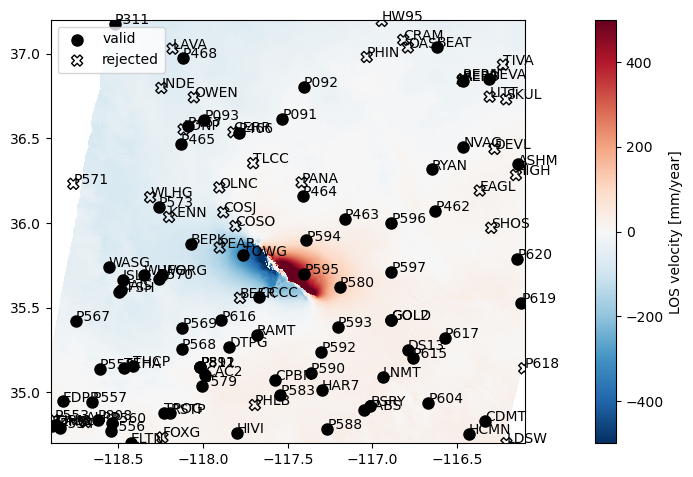

In [29]:
# Plot stations in map view
fig, ax = plt.subplots(figsize=[18, 5.5])
cax = ax.imshow(EQstep, cmap=cmap, vmin=vmin, vmax=vmax,
                interpolation='nearest', extent=(W, E, S, N))
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label('LOS velocity [mm/year]')

# Plot valid stations
for i, gnss_stn in enumerate(gnss_stns.values()):
    # Plot station
    ax.scatter(gnss_stn.site_lon, gnss_stn.site_lat, s=8**2, c='k',
               label=('valid' if i == 0 else None))
    ax.annotate(gnss_stn.site, (gnss_stn.site_lon, gnss_stn.site_lat))

# Plot rejected stations
for i, gnss_stn in enumerate(bad_stns.values()):
    # Plot station
    ax.scatter(gnss_stn.site_lon, gnss_stn.site_lat, s=8**2,
               marker='X', facecolor='none', edgecolor='k',
              label=('rejected' if i == 0 else None))
    ax.annotate(gnss_stn.site, (gnss_stn.site_lon, gnss_stn.site_lat))

ax.legend()

<a id='gps_los'></a>
### 4.5. Make GNSS LOS Velocities/Displacements

One of our goals is to compare the coseismic displacements computed from InSAR, to those observed using continuous GNSS measurements. To make a direct comparison, we first projec the 3D GNSS displacement series into InSAR LOS (using the local incidence and azimuth angles). We then estimate the coseismic steps recorded by the GNSS using two methods:

1. We calculate a simple difference in GNSS station position at two dates bracketing the earthquake. This will likely be a noisy estimate.
2. We fit the LOS-projected GNSS displacement time-series using the same basis functions (i.e., polynomial and step term) that were used to fit the InSAR time-series. For this latter process, outliers are removed from the GNSS position data iteratively and the functional fits are recomputed. This should ensure the most robust estimate of coseismic displacements.

Step function index: 2
site displacement (mm)
ASHM -0.38 +- 1.16 mm
BEAT -1.04 +- 1.00 mm
BEPK -73.40 +- 1.23 mm
BFSH -21.40 +- 1.78 mm
BSRY 0.59 +- 1.05 mm
CABS -0.50 +- 1.16 mm
CAC2 -0.16 +- 1.38 mm
CAIS -22.50 +- 1.46 mm
CAL8 -3.17 +- 1.38 mm
CCCC -70.17 +- 1.48 mm
CDMT 0.25 +- 1.21 mm
CPBN 0.79 +- 1.01 mm
DS13 6.96 +- 1.37 mm
DTPG 2.27 +- 1.23 mm
EDPP -4.37 +- 1.23 mm
ELTN -3.26 +- 1.51 mm
FZHS -2.81 +- 1.52 mm
GOL2 18.40 +- 1.28 mm
GOLD 17.95 +- 1.18 mm
HAR7 -2.07 +- 1.20 mm
HCMN 0.55 +- 1.26 mm
HIVI -1.41 +- 1.72 mm
ISLK -26.35 +- 1.59 mm
LJRN -4.02 +- 1.37 mm
LNMT 1.28 +- 1.18 mm
NEVA 1.53 +- 1.25 mm
NVAG 1.24 +- 1.30 mm
P091 3.48 +- 1.06 mm
P092 1.86 +- 1.13 mm
P093 2.54 +- 1.33 mm
P311 -0.28 +- 1.04 mm
P462 4.98 +- 1.46 mm
P463 16.98 +- 1.25 mm
P464 7.06 +- 1.29 mm
P465 -0.94 +- 1.24 mm
P466 7.57 +- 1.05 mm
P467 -0.73 +- 1.38 mm
P468 -0.83 +- 1.11 mm
P554 -1.27 +- 1.83 mm
P556 -0.39 +- 1.44 mm
P557 -2.64 +- 1.16 mm


/tmp/ipykernel_1866/441284193.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(figsize=(10, 4), ncols=2)


P558 -4.54 +- 1.12 mm
P560 -1.46 +- 1.29 mm
P567 -12.40 +- 1.10 mm
P568 -4.18 +- 1.38 mm
P569 -11.64 +- 1.52 mm
P570 -40.49 +- 1.53 mm
P573 -24.80 +- 1.21 mm
P579 -0.88 +- 1.15 mm
P580 130.07 +- 1.24 mm
P583 0.39 +- 1.03 mm
P588 0.53 +- 1.15 mm
P590 -2.79 +- 1.15 mm
P591 -0.30 +- 1.46 mm
P592 -2.46 +- 1.11 mm
P593 11.14 +- 0.98 mm
P594 65.78 +- 1.28 mm
P595 456.69 +- 1.11 mm
P596 12.02 +- 1.59 mm
P597 30.55 +- 1.23 mm
P604 0.37 +- 1.29 mm
P615 5.53 +- 1.27 mm
P616 -10.51 +- 1.44 mm
P617 6.14 +- 1.34 mm
P619 3.53 +- 1.25 mm
P620 3.74 +- 1.21 mm
P808 -3.12 +- 1.54 mm
P811 -0.19 +- 1.42 mm
P812 -0.56 +- 1.46 mm
RAMT -1.11 +- 1.04 mm
REPO 0.83 +- 1.15 mm
RSTP -0.08 +- 1.25 mm
RYAN 0.91 +- 1.55 mm
TEHA -5.16 +- 1.38 mm
THCP -4.05 +- 1.17 mm
TOWG -312.00 +- 1.59 mm
TPOG -1.26 +- 1.31 mm
WASG -16.92 +- 2.68 mm
WHFG -32.10 +- 1.54 mm
WORG -43.85 +- 2.34 mm


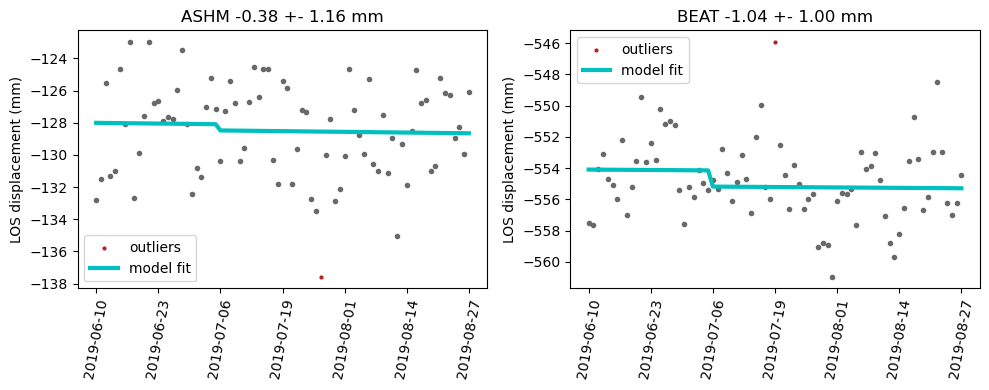

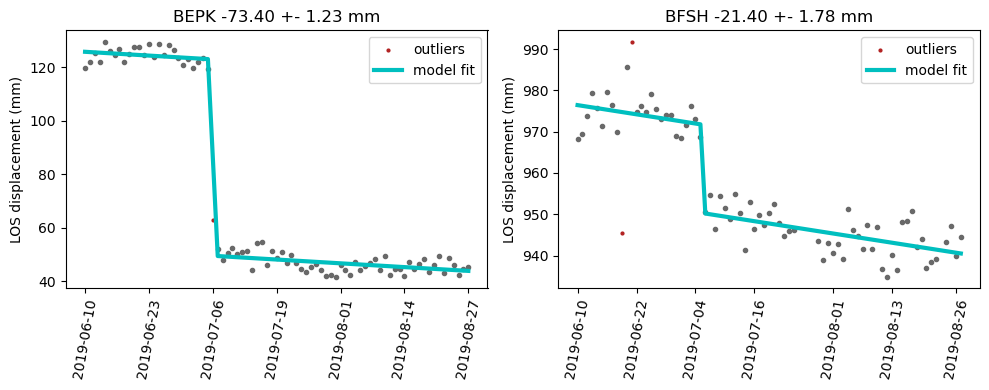

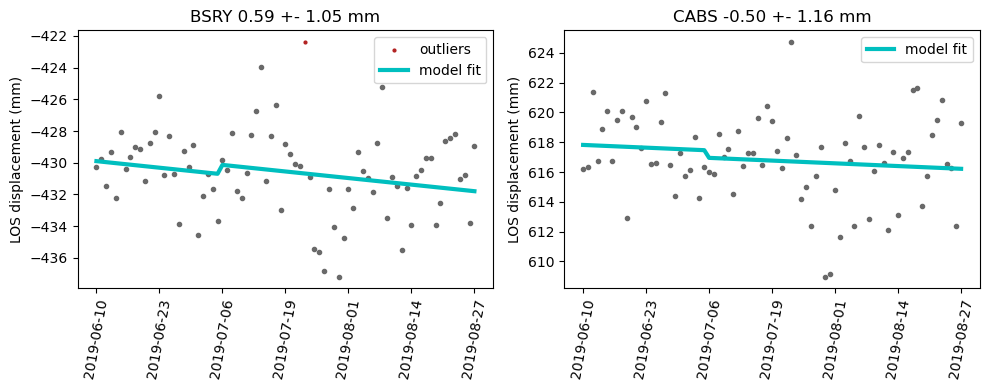

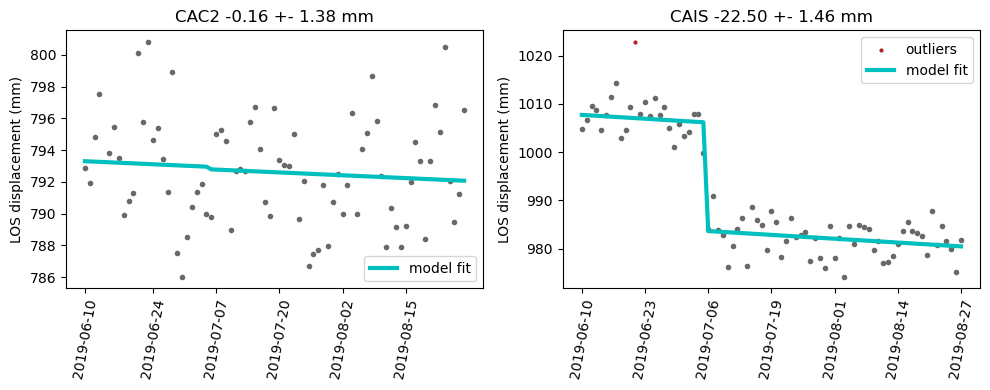

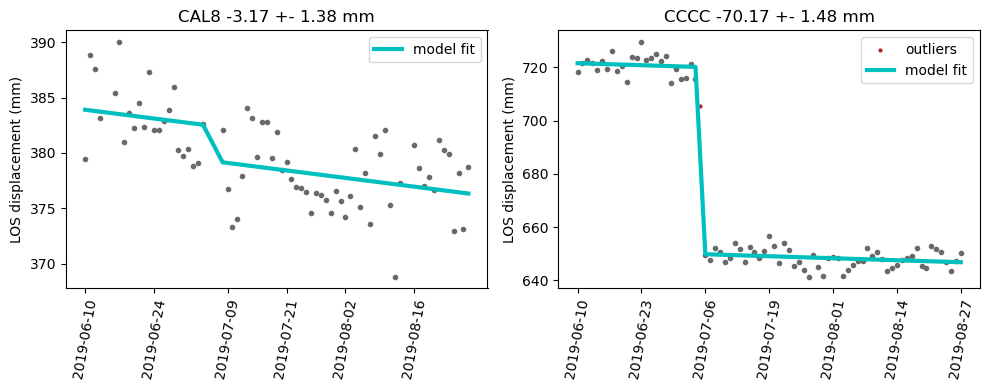

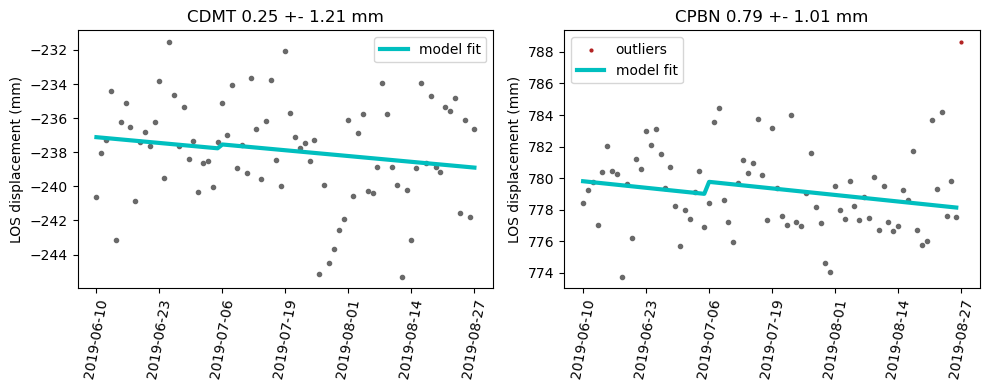

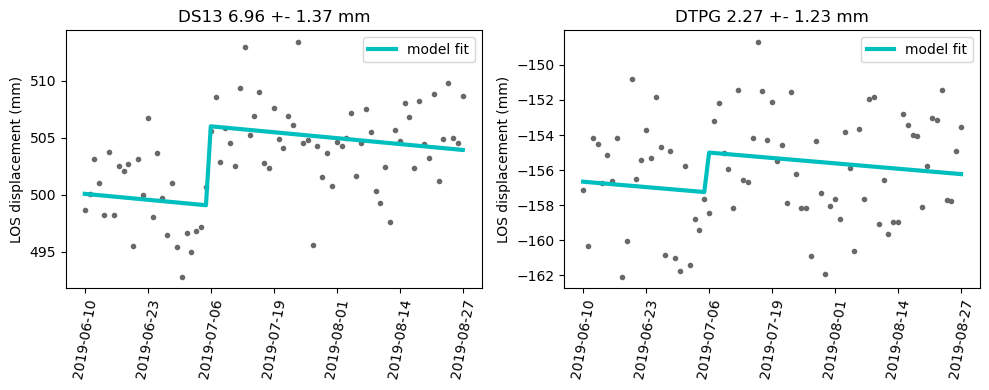

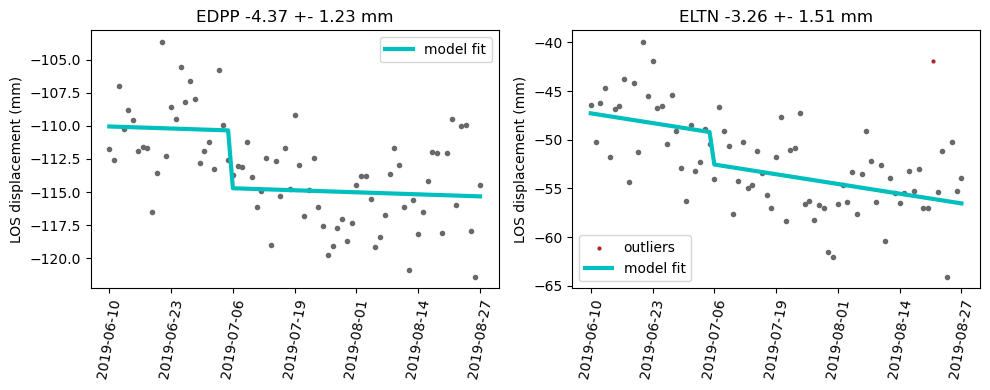

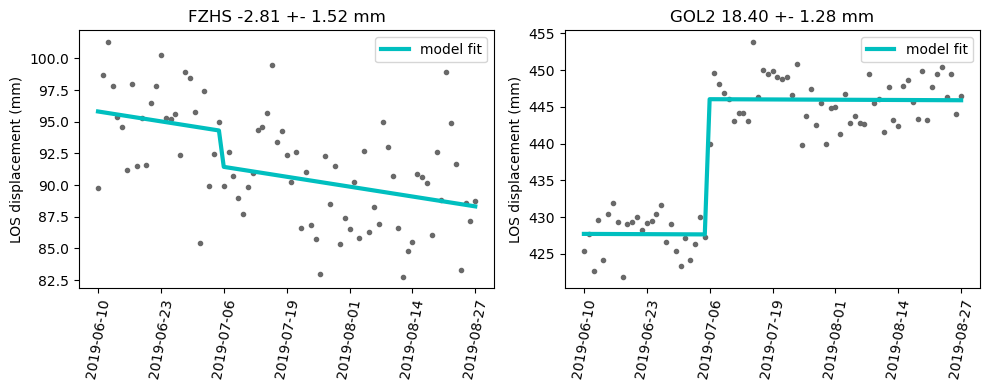

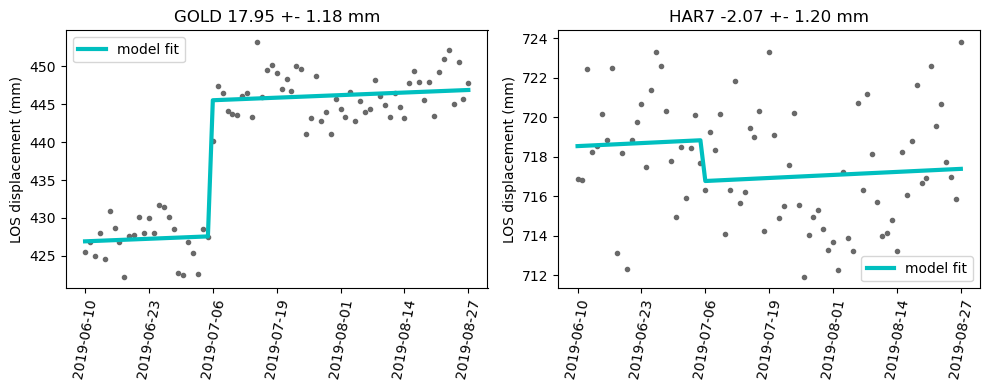

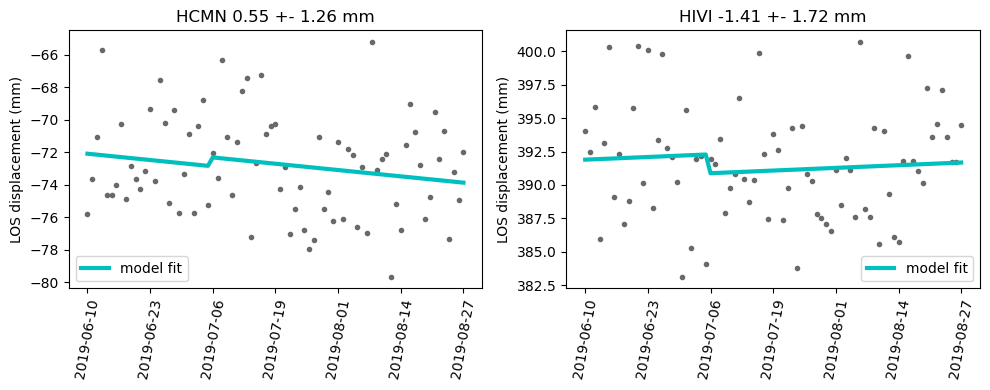

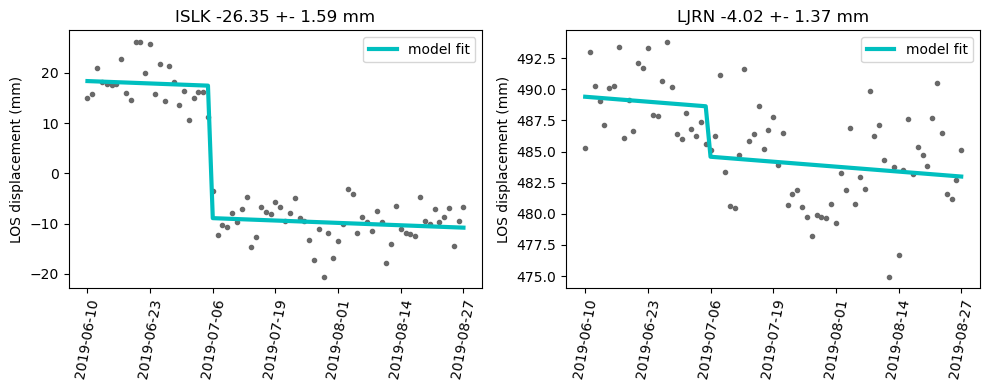

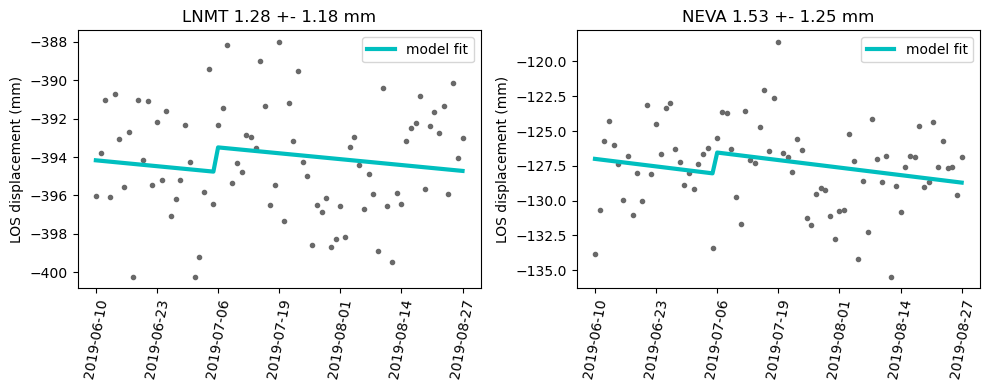

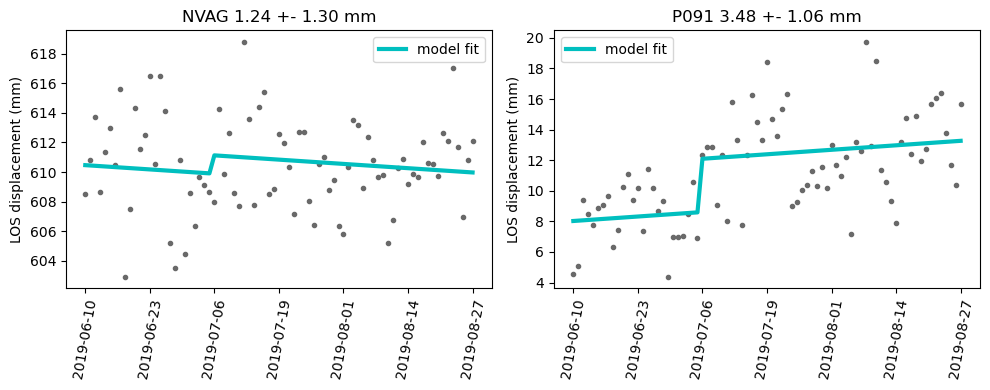

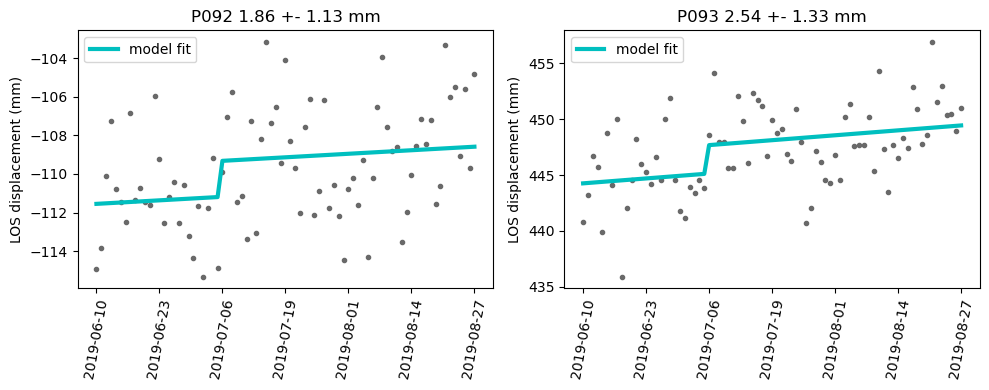

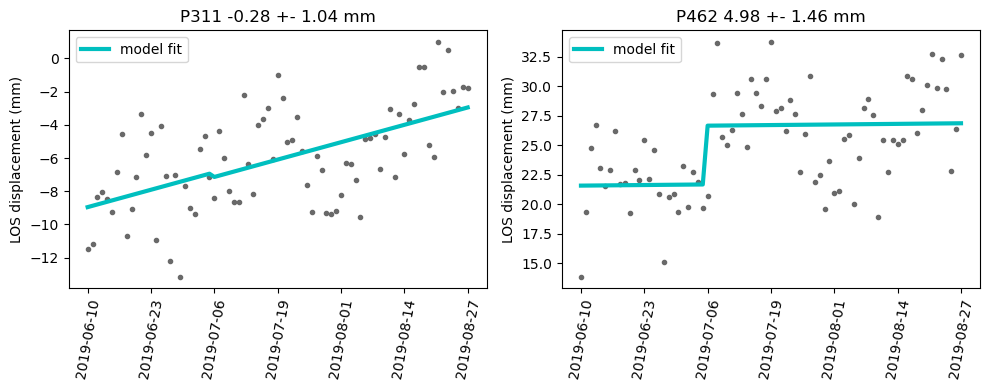

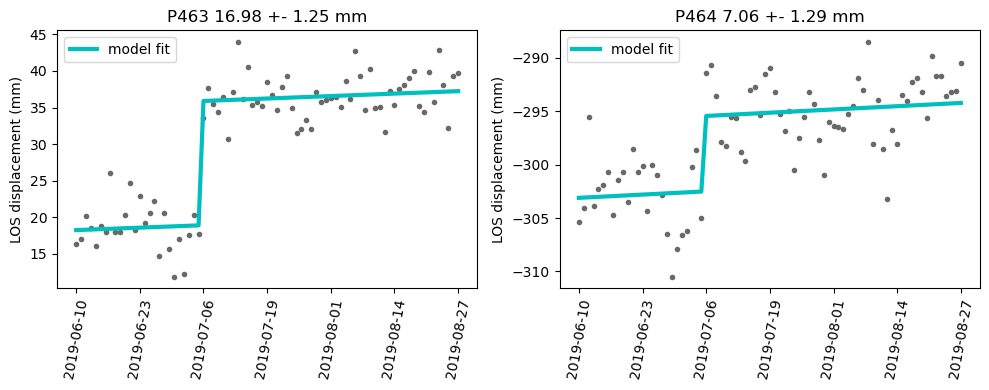

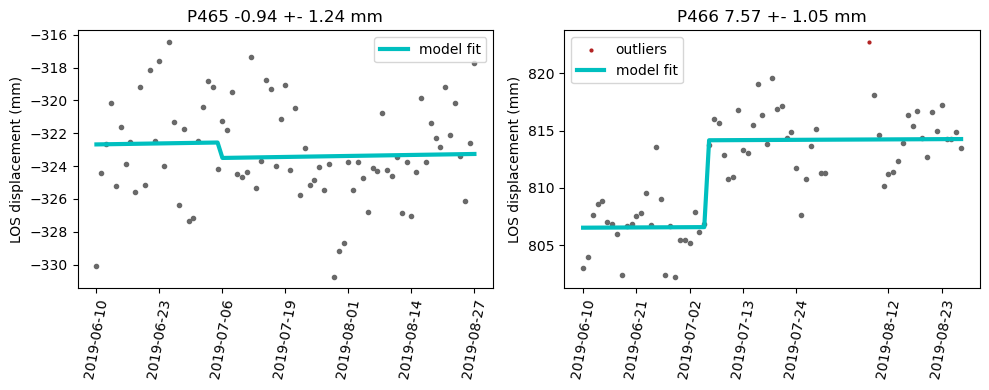

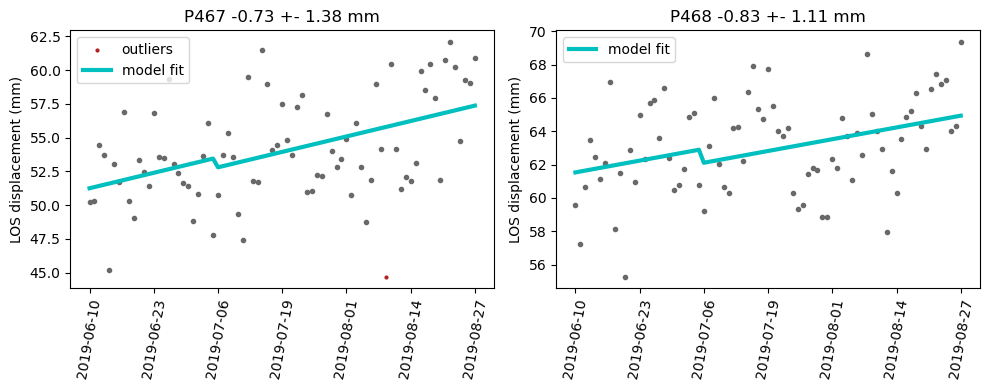

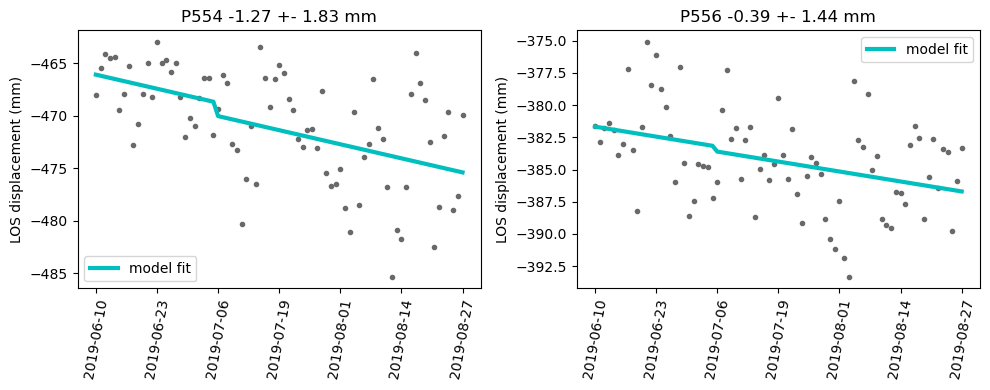

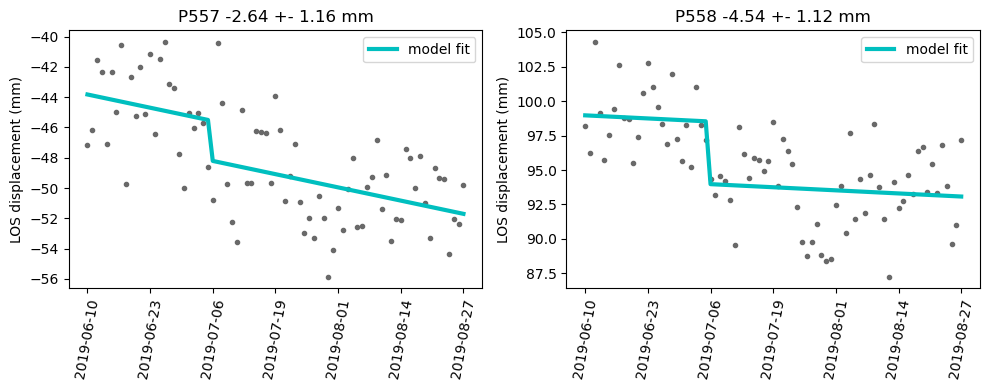

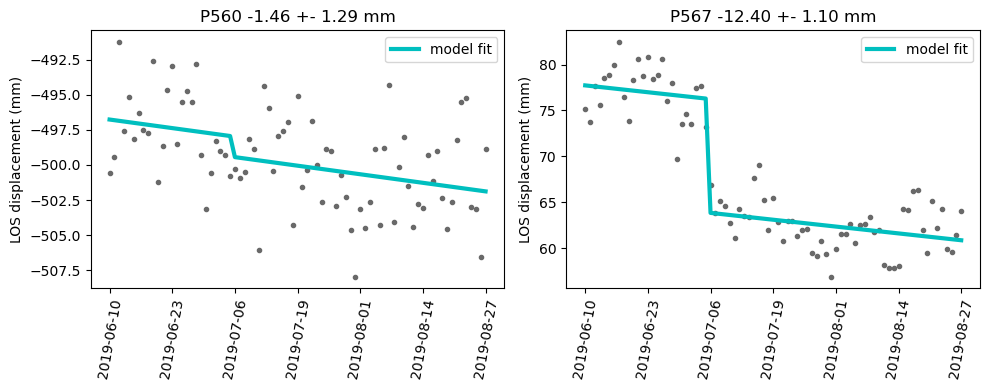

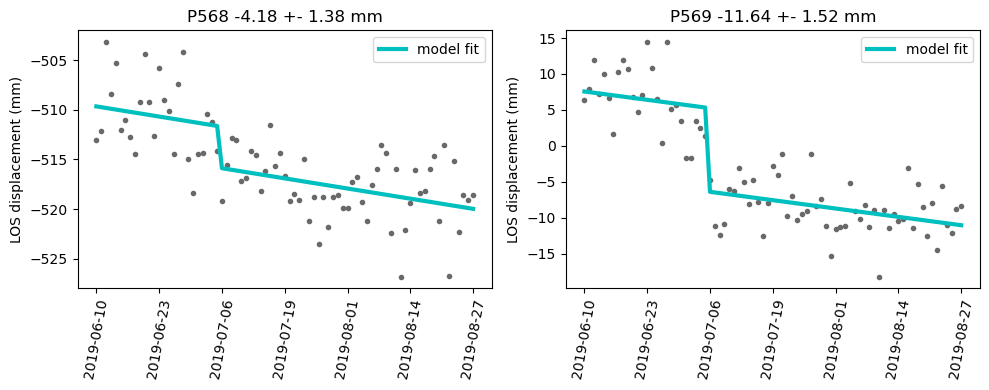

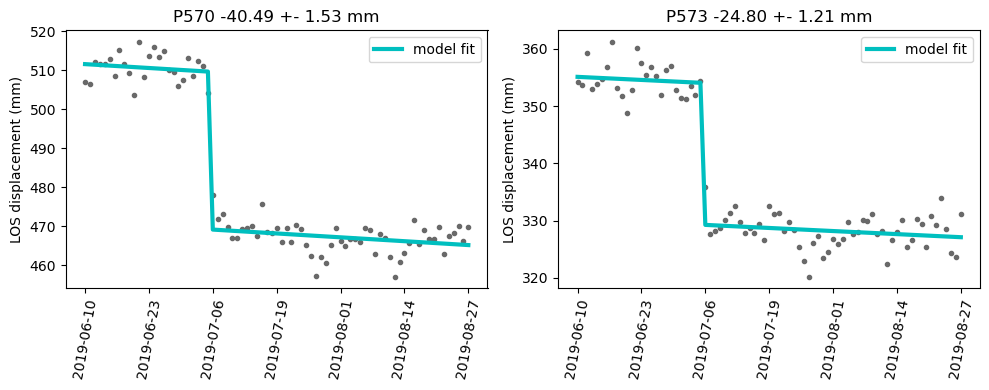

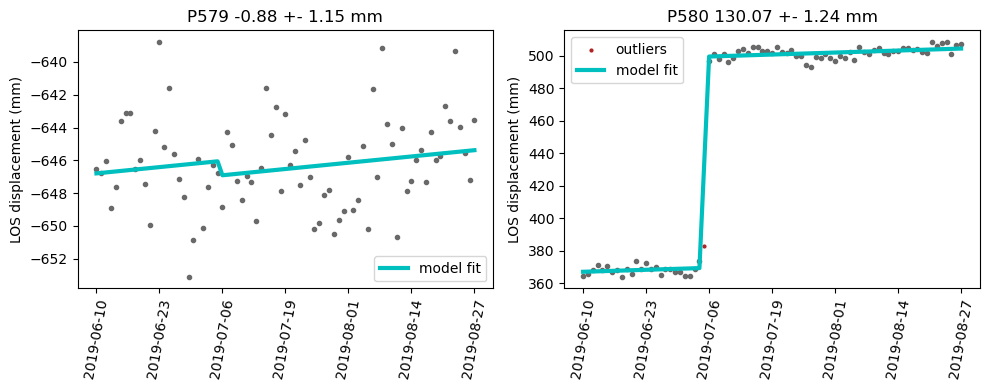

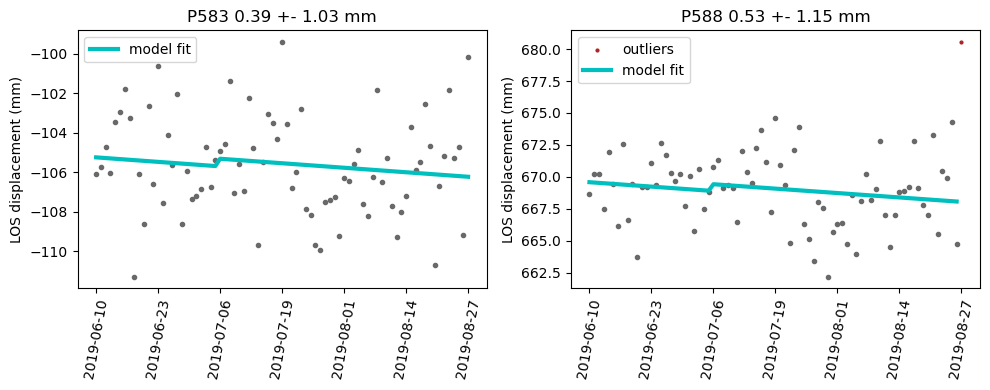

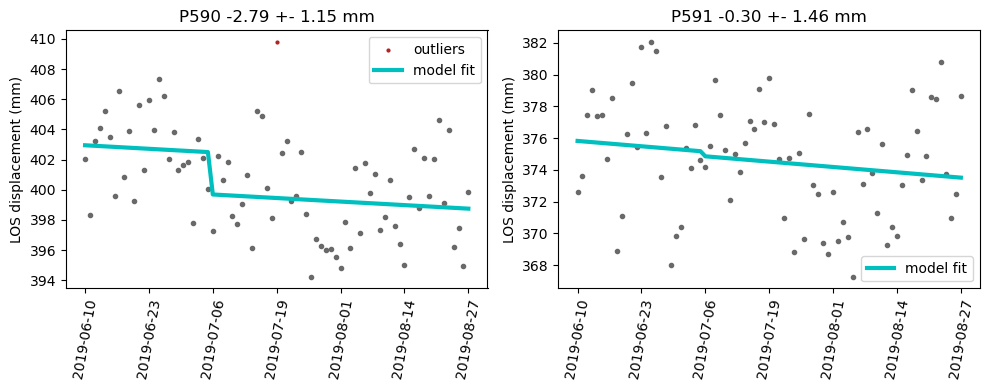

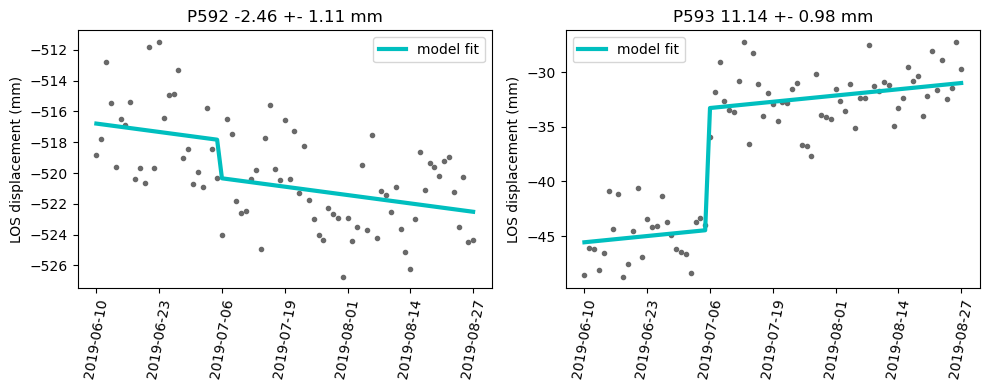

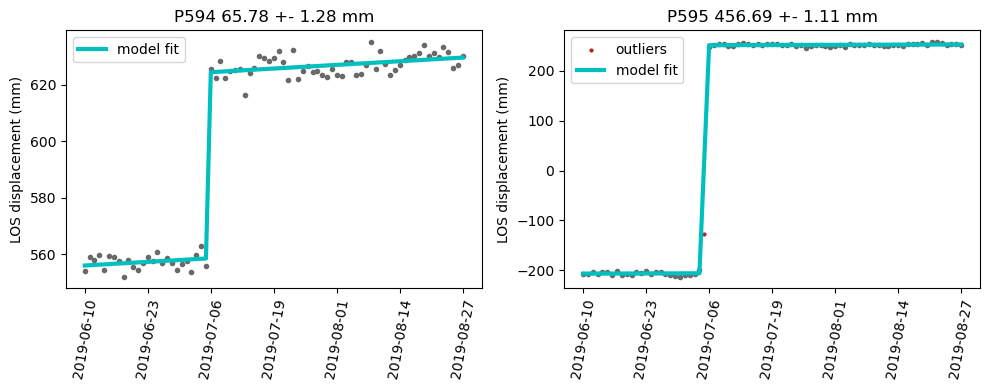

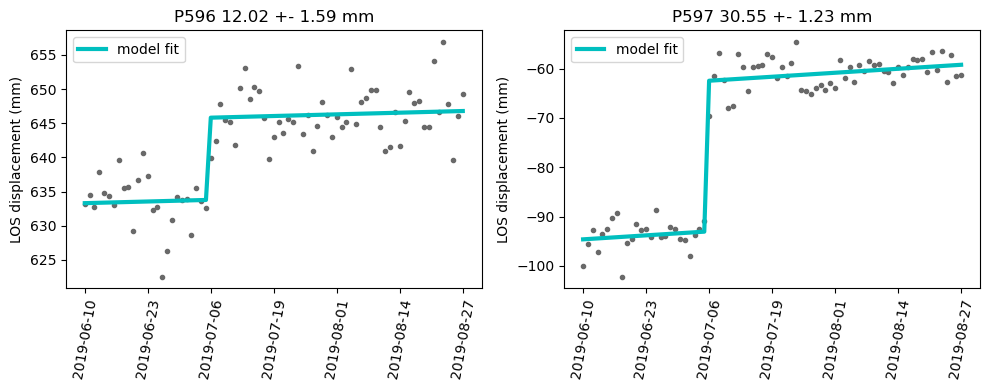

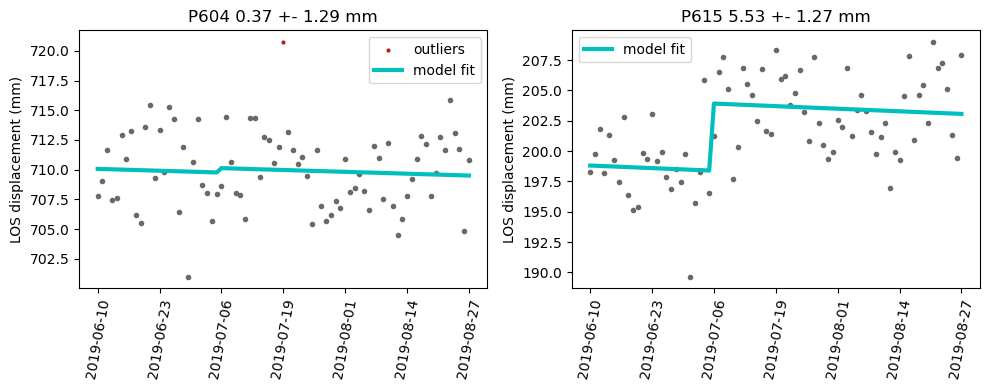

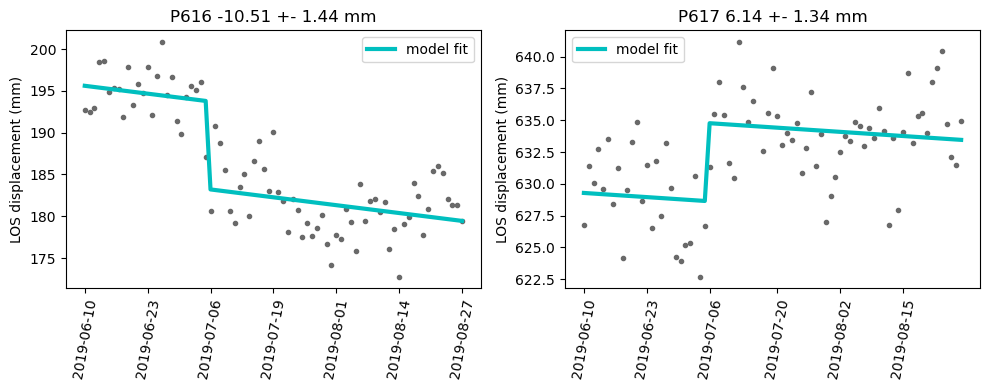

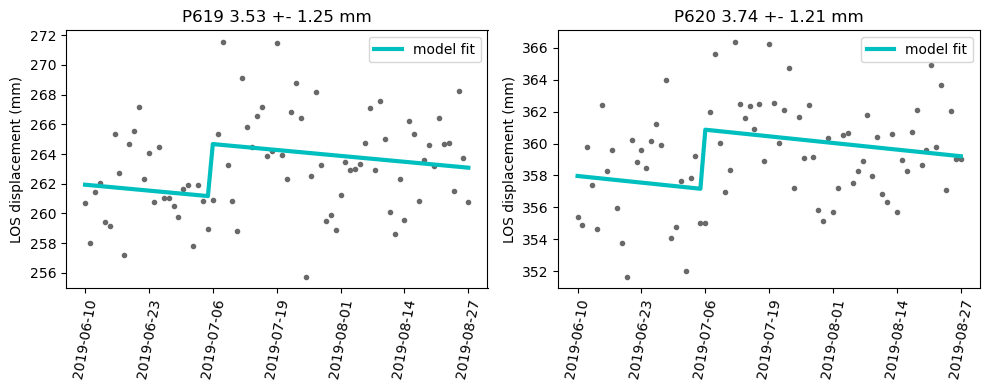

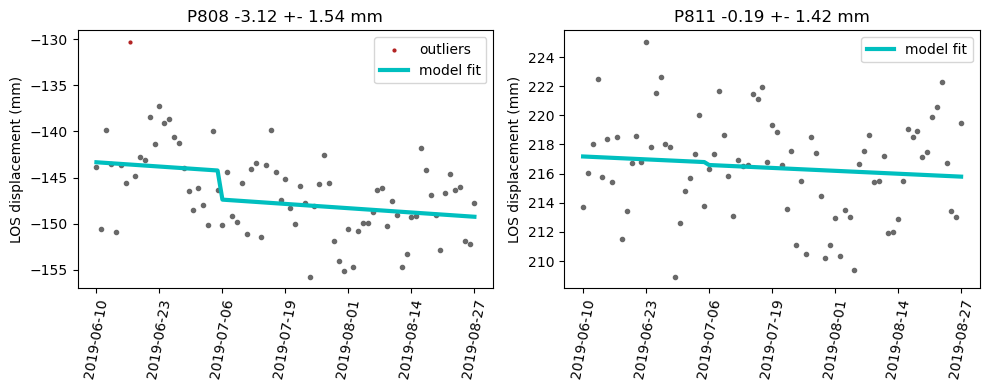

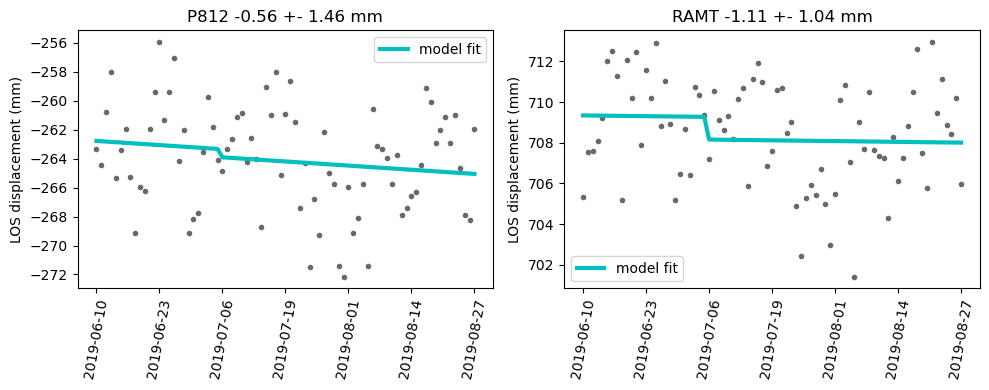

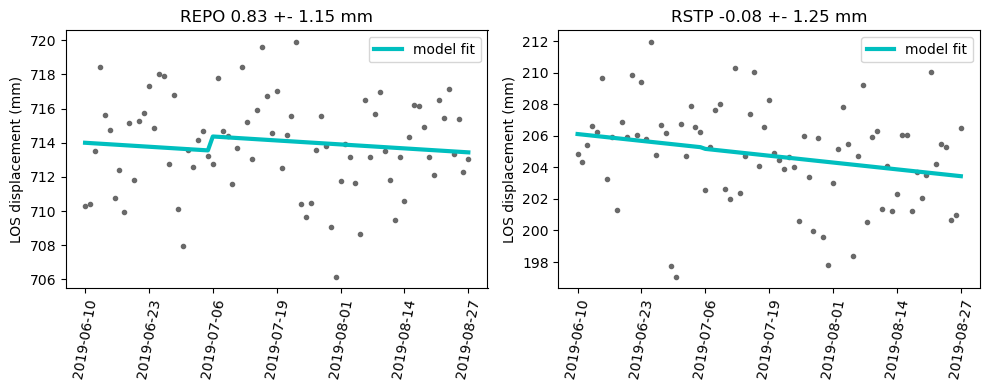

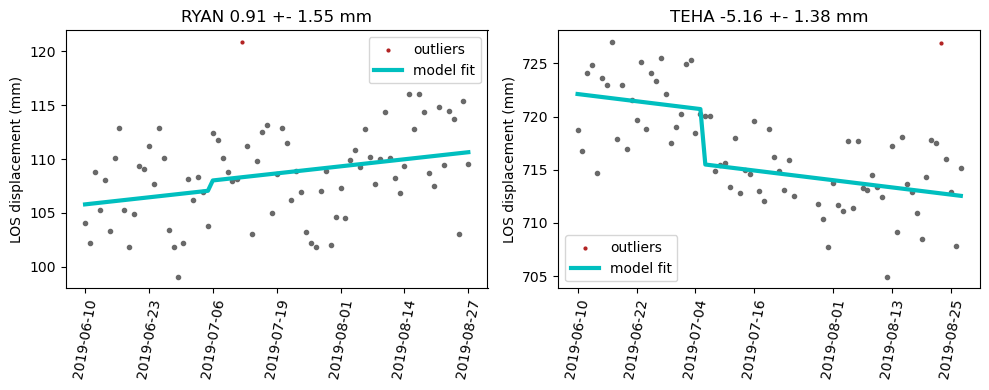

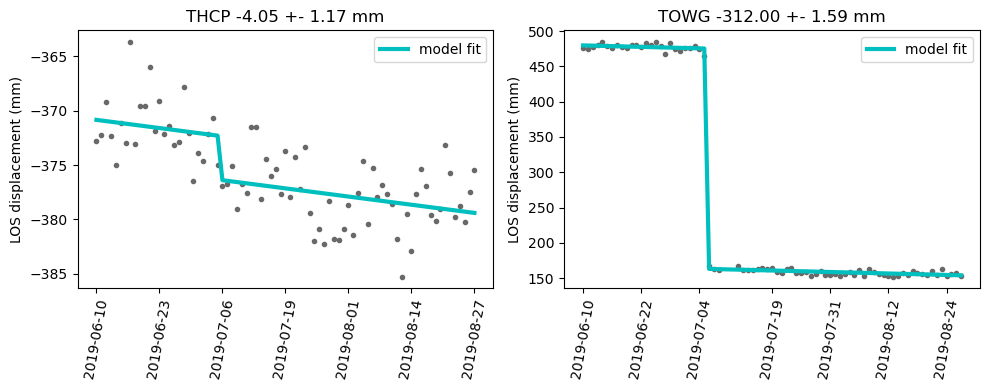

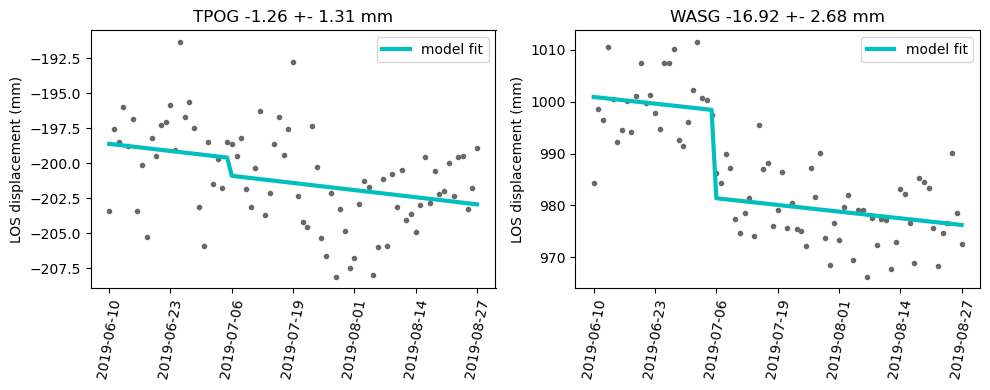

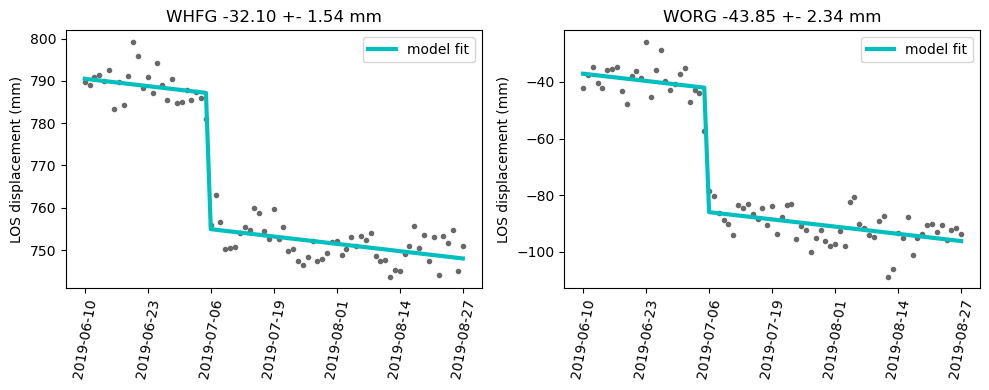

In [30]:
# Outlier ID and removal parameters
outlier_thresh = 3  # standard deviations
outlier_iters = 1  # iterations

# Determine index of step parameter
step_ndx = ts_functions['polynomial'] \
        + len(ts_functions['periodic']) \
        + 1
print(f"Step function index: {step_ndx:d}")

# Loop through valid GNSS stations
gnss_fits = {}  # empty dict to store fits
gnss_sites = {}  # empty dict to store site measurements

for i, site_name in enumerate(site_names):
    # Retrieve station information
    gnss_stn = gnss_stns[site_name]
    gnss_stn.get_los_displacement(insar_metadata,
                                  start_date=start_date,
                                  end_date=end_date)

    # Outlier detection and removal
    gnss_fit = IterativeOutlierFit(gnss_stn.dates, gnss_stn.dis_los,
                                   model=ts_functions, threshold=outlier_thresh,
                                   max_iter=outlier_iters)
    gnss_fits[site_name] = gnss_fit  # record for posterity

    # Record GNSS site velocity
    gnss_site = SiteDisplacement(site=site_name,
                                 site_lon=gnss_stn.site_lon,
                                 site_lat=gnss_stn.site_lat,
                                 dis=gnss_fit.m_hat[step_ndx] * 1000,
                                 dis_err=gnss_fit.mhat_se[step_ndx] * 1000,
                                 unit='mm')
    gnss_sites[site_name] = gnss_site

    # Report
    if i == 0 :
        print('site displacement (mm)')
    print(gnss_site.report())

    # Plotting parameters
    n_dates = len(gnss_stn.dates)
    label_skips = n_dates//6
    ax_nb = i % 2

    # Spawn figure for even numbers
    if ax_nb == 0:
        fig, axes = plt.subplots(figsize=(10, 4), ncols=2)

    # Plot outliers
    if gnss_fit.n_outliers > 0:
        axes[ax_nb].scatter(gnss_fit.outlier_dates,
                            1000*gnss_fit.outlier_dis,
                            2**2, 'firebrick', label='outliers')

    # Plot filtered data and model fit
    axes[ax_nb].scatter(gnss_fit.dates, 1000*gnss_fit.dis, 3**2,
                        'dimgrey', zorder=1)
    axes[ax_nb].plot(gnss_fit.dates, 1000*gnss_fit.dis_hat,
                     'c', linewidth=3, label='model fit', zorder=2)
    
    # Format plot
    axes[ax_nb].legend()
    axes[ax_nb].set_xticks(gnss_stn.dates[::label_skips])
    axes[ax_nb].set_xticklabels([date.strftime('%Y-%m-%d') \
                                 for date in gnss_stn.dates[::label_skips]],
                                rotation=80)
    axes[ax_nb].set_ylabel('LOS displacement (mm)')
    axes[ax_nb].set_title(gnss_site.report())
    fig.tight_layout()


<a id='reference'></a>
### 4.6. Re-reference GNSS and InSAR LOS Coseismic Step


In [ ]:
# Reference GNSS stations to reference site
ref_site = sitedata['sites'][site]['gps_ref_site_name']
if sitedata['sites'][site]['gps_ref_site_name'] == 'auto':
    ref_site = [*gnss_sites.keys()][0]

print(f"Using GNSS reference station: {ref_site}")
gnss_ref_site = gnss_sites[ref_site]

for site_name in site_names:
    gnss_sites[site_name] -= gnss_ref_site
    print(gnss_sites[site_name].report())

# Reference InSAR to GNSS reference site
ref_y, ref_x, _, _ = ut.coordinate(insar_metadata).geo2radar(gnss_ref_site.site_lat,
                                                             gnss_ref_site.site_lon)
zero_msk = (EQstep == 0)
insar_ref_displacement = EQstep[ref_y, ref_x]
print(f"Insar reference displacement {insar_ref_displacement:.1f} mm")
EQstep = EQstep - insar_ref_displacement

# Re-apply mask
EQstep[zero_msk] = np.nan
EQstep[msk == 0] = np.nan

# Plot GNSS stations on InSAR velocity field
fig, ax = plt.subplots(figsize=[18, 5.5])
cax = ax.imshow(np.ma.masked_where((EQstep==0), EQstep),
                cmap=cmap, vmin=vmin, vmax=vmax, interpolation='nearest',
                extent=(W, E, S, N))
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label('LOS velocity [mm]')

for site_name in site_names:
    gnss_site = gnss_sites[site_name]
    color = cmap((gnss_site.dis - vmin)/(vmax-vmin))
    ax.scatter(gnss_site.site_lon, gnss_site.site_lat, color=color, s=8**2, edgecolors='k')
    ax.text(gnss_site.site_lon, gnss_site.site_lat, gnss_site.site)
    ax.set_title(f"{gnss_source} GNSS velocities on InSAR velocities")


<br>
<hr>

<a id='validation1'></a>
## 5. NISAR Validation Approach 1: GNSS-InSAR Direct Comparison 


<a id='make_resid'></a>
### 5.1. Make GNSS-InSAR Displacement Residuals at GNSS Station Locations


To test how well the InSAR measurements agree with the GNSS, we extract the InSAR displacement value at each GNSS site location and compute the differences (residuals) between the two data sets .

In [ ]:
# Set Parameters
pixel_radius = 5   #number of InSAR pixels to average for comparison with GNSS

# Loop over GNSS station locations
insar_sites = {}  # empty dict to store site measurements

for i, site_name in enumerate(site_names):
    gnss_site = gnss_sites[site_name]

    # Convert GNSS station lat/lon information to InSAR x/y grid
    stn_y, stn_x, _, _ = coord.geo2radar(gnss_site.site_lat,
                                         gnss_site.site_lon)

    # Caution: If you expand the radius parameter farther than the bounding grid it will break. 
    # To fix, remove the station in section 4 when the site_names list is filtered
    dis_px_rad = EQstep[stn_y-pixel_radius:stn_y+1+pixel_radius,
                        stn_x-pixel_radius:stn_x+1+pixel_radius]
    insar_site_dis = np.nanmedian(dis_px_rad)

    # Assign to object
    insar_site = SiteDisplacement(site=site_name,
                                  site_lon=gnss_site.site_lon,
                                  site_lat=gnss_site.site_lat,
                                  dis=insar_site_dis,
                                  dis_err=0.,  # dummy for now
                                  unit='mm')
    insar_sites[site_name] = insar_site

    # Report
    if i == 0 :
        print('site displacement(mm)')
    print(insar_site.report())


<a id='make_ddiff'></a>
### 5.2. Make Double-differenced Displacement Residuals (from Step Function Approach)


Adjusting the InSAR velocity field to a single reference site, as done in Section 4.9, leaves room for discrepancies between the InSAR and GNSS data sets. Instead, this validation exercise focuses on the ability to accurately measure relative displacement rates across a scene. To eliminate bias introduced by imprecise registration between the InSAR and GNSS data, we difference the InSAR and GNSS relative velocities between pairs of stations, i.e., the "double-difference" between site pairs.

We compute the double-differences below.

In [ ]:
# Compute double differences between site pairs
n_sites = len(site_names)

# Loop over stations
double_diffs = {}  # empty dict to populate with InSAR - GNSS diffs
for i in range(n_sites - 1):
    stn1 = site_names[i]
    for j in range(i + 1, n_sites):
        stn2 = site_names[j]

        # Calculate differences
        diff_name = f"{stn1}-{stn2}"
        gnss_diff = gnss_sites[stn1] - gnss_sites[stn2]
        insar_diff = insar_sites[stn1] - insar_sites[stn2]
        diff_res = gnss_diff - insar_diff
        diff_res.site = diff_name

        # Compute difference (km) between points
        diff_res.dist = haversine_distance(gnss_sites[stn1].site_lon,
                                           gnss_sites[stn1].site_lat,
                                           gnss_sites[stn2].site_lon,
                                           gnss_sites[stn2].site_lat)

        # Record to dictionary
        double_diffs[diff_name] = diff_res


<a id='amp_vs_dist'></a>
### 5.3. Amplitude vs. Distance of Double-differences (not quite a structure function)

The coseismic requirement is that, for earthquakes that generate surface displacements &ge; 100 mm, at least 68.3% of surface displacements should be measured with an accuracy of $4(1 + \sqrt{L})$ or better, over length scales of $0.1 \mathrm{km} < L < 50 \mathrm{km}$, where $L$ is the distance from one sample point to another. We assume that the distribution of residuals is Gaussian and that the requirement success threshold represents a 1-sigma limit within which we expect 68.3% of residuals to lie.

In [ ]:
# Set requirement thresholds
coseismic_distance_rqmt = (0.1, 50)  # distances for evaluation
coseismic_threshold_rqmt = lambda L: 4 * (1 + np.sqrt(L))  # coseismic threshold in mm

n_bins = 10  # number of distance bins for analysis
threshold = 0.683  # fraction of Gaussian normal distribution for pass/fail

# Define validation parameters
sensor = 'Sentinel-1'
validation_data = 'GNSS'

# Write data for statistical tests
site_dist = np.array([diff_res.dist for diff_res in double_diffs.values()])
double_diff_rel_measure = np.abs(np.array([diff_res.dis for diff_res in double_diffs.values()]))
double_diff_rel_measure_err = np.array([diff_res.dis_err for diff_res in double_diffs.values()])

# Validation figure and assessment
(validation_table,
 fig) = display_coseismic_validation(site_dist,                           # binned distance for point
                                     double_diff_rel_measure,             # binned double-difference velocities mm/yr
                                     site,                                # cal/val site name
                                     start_date,                          # start date of InSAR dataset
                                     end_date,                            # end date of InSAR dataset 
                                     requirement=coseismic_threshold_rqmt,  # measurement requirement to meet, e.g 2 mm/yr for 3 years of data over 0.1-50km
                                     distance_rqmt=coseismic_distance_rqmt, # distance over requirement is to meet, e.g. over length scales of 0.1-50 km [0.1, 50] 
                                     n_bins=n_bins,                       # number of bins, to collect statistics 
                                     threshold=threshold,                 # quantile threshold for point-pairs that pass requirement, e.g. 0.683 - we expect 68.3% of residuals to lie. 
                                     sensor='Sentinel-1',                 # sensor that is validated, Sentinel-1 or NISAR
                                     validation_type=requirement.lower(), # validation for: secular, transient, coseismic requirement
                                     validation_data='GNSS (step)') # validation method: GNSS - Method 1, InSAR - Method 2


This is similar to &ndash; though not strictly &ndash; a structure function that shows difference in displacement values as a function of distance.

In [ ]:
display_validation_table(validation_table)

<div class="alert alert-warning">
Final result Method 1—Succesful when 68.3% of points below requirements line
</div>


<a id='validation2'></a>
## 6. NISAR Validation Approach 2: InSAR-only Structure Function

In Validation Approach 2, we use a date when there was no earthquake and do the same step function fit.

In [ ]:
# Check that an earthquake date is specified and retrieve that date
if 'noEarthquakeDate' in sitedata['sites'][site].keys():
    noEQdate = [sitedata['sites'][site]['noEarthquakeDate']]
    print('No-earthquake date: {:s}'.format(sitedata['sites'][site]['noEarthquakeDate']))
else:
    noEQdate = []
    warnings.warn('No non-earthquake date specified. This data set might not be suitable for the coseismic workflow.')

In [ ]:
os.chdir(mintpy_dir)  # reset directory in case running out of sequence
print(f"Present directory: {mintpy_dir:s}")

# Step function fit when there was no earthquake
command = 'timeseries2velocity.py ' + timeseries_filename + ' --step ' + sitedata['sites'][site]['noEarthquakeDate']
process = subprocess.run(command, shell=True)

Now we can view the step function amplitude for the non-earthquake date and the new linear velocity estimate. Because we have the step function at a time far away from the earthquake, the step function has a small amplitude and the linear velocity has absorbed the time-series displacements. The non-earthquake step plot has the same color scale as the earthquake coseismic plot above to show the small atmospheric noise of a date without an earthquake.

In [ ]:
scp_args = 'velocity.h5 step' + sitedata['sites'][site]['noEarthquakeDate'] + ' -v -500 500 --colormap RdBu --unit mm --figtitle LOS_Coseismic'
view.main(scp_args.split())
scp_args = 'velocity.h5 velocity -v -250 250 --colormap RdBu --unit mm/yr --figtitle LOS_Velocity'
view.main(scp_args.split())

<a id='array_mask'></a>
### 6.1. Read Array and Mask Pixels with no Data

In [ ]:
# Use the non-earthquake displacement as the insar_displacment for statistics and convert to mm
noEQdataset = 'step' + sitedata['sites'][site]['noEarthquakeDate']
noEQstep, insar_metadata = readfile.read(vel_file, datasetName = noEQdataset)  #read coseismic step 
(S,N,W,E) = ut.four_corners(insar_metadata)
noEQdate = sitedata['sites'][site]['noEarthquakeDate']

insar_displacement = noEQstep * 1000. # convert from m to mm and add dimension to array to allow multiple datasets

ifgs_date = np.array([noEQdate])  # only one non-earthquake date for now
n_ifgs = insar_displacement.shape[0]

# Mask out no-data areas
msk, _ = readfile.read(msk_file)
insar_displacement[msk == 0] = np.nan
insar_displacement[insar_displacement == 0] = np.nan

# Display map of data after masking
cmap = plt.get_cmap('RdBu')
fig, ax = plt.subplots(figsize=[18, 5.5])
img1 = ax.imshow(insar_displacement, cmap=cmap, interpolation='nearest', extent=(W, E, S, N))
ax.set_title("Coseismic \n Date "+noEQdate)
cbar1 = fig.colorbar(img1, ax=ax)
cbar1.set_label('LOS displacement [mm]')

<a id='remove_trend'></a>
### 6.2. Randomly Sample Pixels and Pair Them Up with Option to Remove Trend

First, calculate the coordinate for every pixel.

Then for each non-earthquake step fit, randomly selected pixels need to be paired up. In order to keep measurements independent, different pixel pairs can not share same pixel. This is achieved by pairing up in sequence, i.e., pairing up pixel number 1 and number 2, 3 and 4...

To pass the requirement, the pixel-to-pixels differences must satisfy the same $4(1 + \sqrt{L})$ or better, over length scales of $0.1 \mathrm{km} < L < 50 \mathrm{km}$ requirement specified above.

In [ ]:
# Set requirement thresholds
coseismic_distance_rqmt = (0.1, 50)  # distances for evaluation
coseismic_threshold_rqmt = lambda L: 4 * (1 + np.sqrt(L))  # coseismic threshold in mm

n_bins = 10  # number of distance bins for analysis
threshold = 0.683  # fraction of Gaussian normal distribution for pass/fail

sensor = 'Sentinel-1'
validation_data = 'InSAR'

In [ ]:
sample_mode = 'points'  # 'points' or 'profile'
# note that the 'profile' method may take significantly longer

# Collect samples using the specified method
if sample_mode in ['points']:
    X0,Y0 = load_geo(insar_metadata)
    X0_2d,Y0_2d = np.meshgrid(X0,Y0)

    insar_sample_dist, insar_rel_measure = samp_pair(X0_2d, Y0_2d, insar_displacement, num_samples=1000000)

elif sample_mode in ['profile']:
    # Sample grid setup
    length, width = int(insar_metadata['LENGTH']), int(insar_metadata['WIDTH'])
    X = np.linspace(W+lon_step, E-lon_step, width)  # longitudes
    Y = np.linspace(N+lat_step, S-lat_step, length)  # latitudes
    X_coords, Y_coords = np.meshgrid(X, Y)

    # Draw random samples from map (without replacement)
    num_samples = 20000
    
    # Retrieve profile samples
    insar_sample_dist, insar_rel_measure = profile_samples(\
                    x=X_coords.reshape(-1,1),
                    y=Y_coords.reshape(-1,1),
                    data=insar_displacement,
                    metadata=insar_metadata,
                    len_rqmt=secular_distance_rqmt,
                    num_samples=num_samples)

Check the statistical property of selected pixel pairs and overall histogram of relative measurements

In [ ]:
fig, ax = plt.subplots(figsize=[18, 5.5])
img1 = ax.hist(insar_sample_dist, bins=100)
ax.set_title(f"Histogram of distance \n Coseismic Date "+noEQdate)
ax.set_xlabel(r'Distance ($km$)')
ax.set_ylabel('Frequency')
ax.set_xlim(0,50)
    
fig, ax = plt.subplots(figsize=[18, 5.5])
img1 = ax.hist(insar_rel_measure, bins=100)
ax.set_title(f"Histogram of Relative Measurement \n Coseismic Date "+noEQdate)
ax.set_xlabel(r'Relative Measurement ($mm$)')
ax.set_ylabel('Frequency')

<a id='validation2'></a>
### 6.3. Coseismic Requirement Validation: Method 2


In approach 2, the number of pixel pairs which meet the mission requirement as a percentage of the total number of pixel pairs selected are counted.

The method we apply to evaluate the noise structure is similar to that in the InSAR-GNSS comparison. We count the percentage of measurements that fall below the threshold curve  for each of the 5-km-wide bins. If the average of the percentages from all bins is larger than 0.683, we judge that the noise level falls below the requirement.

Then we prepare table of results.

In [ ]:
# Validation figure and assessment
(validation_table,
 fig) = display_coseismic_validation(insar_sample_dist,                   # binned distance for point
                                     insar_rel_measure,                   # binned double-difference velocities mm/yr
                                     site,                                # cal/val site name
                                     start_date,                          # start date of InSAR dataset
                                     end_date,                            # end date of InSAR dataset 
                                     requirement=coseismic_threshold_rqmt,  # measurement requirement to meet, e.g 2 mm/yr for 3 years of data over 0.1-50km
                                     distance_rqmt=coseismic_distance_rqmt, # distance over requirement is to meet, e.g. over length scales of 0.1-50 km [0.1, 50] 
                                     n_bins=n_bins,                       # number of bins, to collect statistics 
                                     threshold=threshold,                 # quantile threshold for point-pairs that pass requirement, e.g. 0.683 - we expect 68.3% of residuals to lie. 
                                     sensor='Sentinel-1',                 # sensor that is validated, Sentinel-1 or NISAR
                                     validation_type=requirement.lower(), # validation for: secular, transient, coseismic requirement
                                     validation_data=validation_data)     # validation method: GNSS - Method 1, InSAR - Method 2

out_fig = os.path.abspath('coseismic_insar-only_vs_distance_'+site+'_date'+noEQdate+'.png')
fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

In [ ]:
display_validation_table(validation_table)

<div class="alert alert-warning">
Final result Method 2 table of distance bins—
    68% of points below the requirements line is success
</div>


<a id='appendix'></a>
## Appendix: Supplementary Comparisons and Plots


<a id='compare_raw'></a>
### A.1. Compare Raw Displacements


In [ ]:
vmin, vmax = -250, 250
plt.figure(figsize=(10,3))
plt.hist([insar_site.dis for insar_site in insar_sites.values()],
         range=[vmin, vmax], bins=50, color="green", edgecolor='grey', label='V_InSAR')
plt.hist([gnss_site.dis for gnss_site in gnss_sites.values()],
         range=[vmin, vmax], bins=50, color="orange", edgecolor='grey', label='V_gnss', alpha=0.5)
plt.legend(loc='upper right')
plt.title(f'''Displacements \n Date range {start_date}-{end_date}
Reference stn: {sitedata['sites'][site]['gps_ref_site_name']}
Number of stations used: {len(site_names)}''')
plt.xlabel('LOS Displacement (mm)')
plt.ylabel('N Stations')
plt.show()

<a id='plot_residuals'></a>
### A.2. Plot Displacement Residuals


In [ ]:
vmin, vmax = -250, 250
plt.figure(figsize=(10,3))
plt.hist([(insar_sites[site_name] - gnss_sites[site_name]).dis for site_name in site_names],
         bins = 40, range=[vmin,vmax], edgecolor='grey', color="darkblue", linewidth=1,
         label='V_gnss - V_InSAR (area average)')
plt.legend(loc='upper right')
plt.title(f'''Residuals \n Date range {start_date}-{end_date}
Reference stn: {sitedata['sites'][site]['gps_ref_site_name']}
Number of stations used: {len(site_names)}''')
plt.xlabel('Displacement Residual (mm)')
plt.ylabel('N Stations')
plt.show()

<a id='plot_ddiff'></a>
### A.3. Plot Double-differenced Residuals


In [ ]:
vmin, vmax = -250, 250
plt.figure(figsize=(10,3))
plt.hist([diff_res.dis for diff_res in double_diffs.values()],
         range = [vmin, vmax],bins = 40, color = "darkblue",edgecolor='grey',
         label='V_gnss_(s1-s2) - V_InSAR_(s1-s2)')
plt.legend(loc='upper right')
plt.title(f'''Difference Residualts \n Date range {start_date}-{end_date}
Reference stn: {sitedata['sites'][site]['gps_ref_site_name']}
Number of stations used: {len(site_names)}''')
plt.xlabel('Double Differenced Velocity Residual (mm)')
plt.ylabel('N Stations')
plt.show()

<a id='plot_timeseries'></a>
### A.4. GNSS Time-series Plots


In [ ]:
# Grab the time-series file used for time function estimation given the template setup
template = readfile.read_template(os.path.join(mintpy_dir, 'smallbaselineApp.cfg'))
template = ut.check_template_auto_value(template)
ts_file = TimeSeriesAnalysis.get_timeseries_filename(template, mintpy_dir)['velocity']['input']

# Read the time-series file
insar_ts, ts_metadata = readfile.read(ts_file, datasetName='timeseries')
mask = readfile.read(os.path.join(mintpy_dir, 'maskTempCoh.h5'))[0]
print(f"reading timeseries from file: {ts_file}")

# Get date list
date_list = timeseries(ts_file).get_date_list()
num_date = len(date_list)
date0, date1 = date_list[0], date_list[-1]
insar_dates = ptime.date_list2vector(date_list)[0]

# Spatial reference
coord = ut.coordinate(ts_metadata)
ref_site = sitedata['sites'][site]['gps_ref_site_name']
ref_gnss_obj = gnss_stns[ref_site]
ref_lat, ref_lon = ref_gnss_obj.get_site_lat_lon()
ref_y, ref_x = coord.geo2radar(ref_lat, ref_lon)[:2]
if not mask[ref_y, ref_x]:
    raise ValueError(f'Given reference GNSS site ({ref_site}) is in mask-out unrelible region in InSAR! Change to a different site.')
ref_insar_dis = insar_ts[:, ref_y, ref_x]

# Plot displacements and velocity timeseries at GNSS station locations
num_site = len(site_names)
prog_bar = ptime.progressBar(maxValue=num_site)
for i, site_name in enumerate(site_names):
    prog_bar.update(i+1, suffix=f'{site_name} {i+1}/{num_site}')

    ## Read data
    # Recall gnss station displacements with outliers removed
    gnss_obj = gnss_stns[site_name]
    gnss_lalo = (gnss_obj.site_lat, gnss_obj.site_lon)

    # Get relative LOS displacement on common dates
    gnss_dates = np.array(sorted(list(set(gnss_obj.dates) & set(ref_gnss_obj.dates))))
    gnss_dis = np.zeros(gnss_dates.shape, dtype=np.float32)
    for i, date_i in enumerate(gnss_dates):
        idx1 = np.where(gnss_obj.dates == date_i)[0][0]
        idx2 = np.where(ref_gnss_obj.dates == date_i)[0][0]
        gnss_dis[i] = gnss_obj.dis_los[idx1] - ref_gnss_obj.dis_los[idx2]
    
    # Shift GNSS to zero-mean in time [for plotting purpose]
    gnss_dis -= np.nanmedian(gnss_dis)

    # Read InSAR
    y, x = coord.geo2radar(gnss_lalo[0], gnss_lalo[1])[:2]
    insar_dis = insar_ts[:, y, x] - ref_insar_dis

    # Apply a constant shift in time to fit InSAR to GNSS
    comm_dates = sorted(list(set(gnss_dates) & set(insar_dates)))
    if comm_dates:
        insar_flag = [x in comm_dates for x in insar_dates]
        gnss_flag = [x in comm_dates for x in gnss_dates]
        insar_dis -= np.nanmedian(insar_dis[insar_flag] - gnss_dis[gnss_flag])

    ## Plot figure
    if gnss_dis.size > 0 and np.any(~np.isnan(insar_dis)):
        fig, ax = plt.subplots(figsize=(10, 3))
        ax.axhline(color='grey',linestyle='dashed', linewidth=2)
        ax.scatter(gnss_dates, gnss_dis*1000, s=2**2, label="GNSS Daily Positions")
        ax.scatter(insar_dates, insar_dis*1000, label="InSAR Positions")
        # axis format
        ax.set_title(f"Station Name: {site_name}") 
        ax.set_ylabel('LOS displacement [mm]')
        ax.legend()
prog_bar.close()
plt.show()
